In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2259832, 828)
(2259832, 8)
validation
(301336, 828)
(301336, 8)
test
(322056, 828)
(322056, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/226 [..............................] - ETA: 6:13 - loss: 2.2999 - STD: 0.0714 - MAE: 0.2201

  4/226 [..............................] - ETA: 4s - loss: 2.1355 - STD: 0.0537 - MAE: 0.2173  

  7/226 [..............................] - ETA: 5s - loss: 2.1169 - STD: 0.0528 - MAE: 0.2168

 10/226 [>.............................] - ETA: 5s - loss: 2.1039 - STD: 0.0490 - MAE: 0.2168

 13/226 [>.............................] - ETA: 4s - loss: 2.0927 - STD: 0.0470 - MAE: 0.2166

 16/226 [=>............................] - ETA: 4s - loss: 2.0852 - STD: 0.0451 - MAE: 0.2166

 19/226 [=>............................] - ETA: 4s - loss: 2.0802 - STD: 0.0426 - MAE: 0.2166

 22/226 [=>............................] - ETA: 4s - loss: 2.0749 - STD: 0.0402 - MAE: 0.2167

 25/226 [==>...........................] - ETA: 4s - loss: 2.0693 - STD: 0.0394 - MAE: 0.2166

 28/226 [==>...........................] - ETA: 4s - loss: 2.0633 - STD: 0.0395 - MAE: 0.2164

 31/226 [===>..........................] - ETA: 4s - loss: 2.0562 - STD: 0.0395 - MAE: 0.2162

 34/226 [===>..........................] - ETA: 4s - loss: 2.0472 - STD: 0.0398 - MAE: 0.2158

 37/226 [===>..........................] - ETA: 4s - loss: 2.0367 - STD: 0.0408 - MAE: 0.2154

 40/226 [====>.........................] - ETA: 4s - loss: 2.0258 - STD: 0.0426 - MAE: 0.2149

 43/226 [====>.........................] - ETA: 4s - loss: 2.0145 - STD: 0.0446 - MAE: 0.2144

 46/226 [=====>........................] - ETA: 4s - loss: 2.0032 - STD: 0.0466 - MAE: 0.2138

 49/226 [=====>........................] - ETA: 4s - loss: 1.9915 - STD: 0.0486 - MAE: 0.2133

 52/226 [=====>........................] - ETA: 3s - loss: 1.9804 - STD: 0.0505 - MAE: 0.2127

 55/226 [======>.......................] - ETA: 3s - loss: 1.9689 - STD: 0.0523 - MAE: 0.2122

 58/226 [======>.......................] - ETA: 3s - loss: 1.9573 - STD: 0.0539 - MAE: 0.2117

 61/226 [=======>......................] - ETA: 3s - loss: 1.9453 - STD: 0.0556 - MAE: 0.2111

 64/226 [=======>......................] - ETA: 3s - loss: 1.9327 - STD: 0.0573 - MAE: 0.2105

 67/226 [=======>......................] - ETA: 3s - loss: 1.9202 - STD: 0.0591 - MAE: 0.2099

 70/226 [========>.....................] - ETA: 3s - loss: 1.9077 - STD: 0.0608 - MAE: 0.2093

 73/226 [========>.....................] - ETA: 3s - loss: 1.8949 - STD: 0.0626 - MAE: 0.2086

 76/226 [=========>....................] - ETA: 3s - loss: 1.8822 - STD: 0.0644 - MAE: 0.2079

 79/226 [=========>....................] - ETA: 3s - loss: 1.8698 - STD: 0.0662 - MAE: 0.2072

 82/226 [=========>....................] - ETA: 3s - loss: 1.8577 - STD: 0.0680 - MAE: 0.2065

 85/226 [==========>...................] - ETA: 3s - loss: 1.8458 - STD: 0.0698 - MAE: 0.2058

 88/226 [==========>...................] - ETA: 3s - loss: 1.8344 - STD: 0.0716 - MAE: 0.2051

 91/226 [===========>..................] - ETA: 3s - loss: 1.8231 - STD: 0.0734 - MAE: 0.2044

 94/226 [===========>..................] - ETA: 2s - loss: 1.8120 - STD: 0.0752 - MAE: 0.2036

 97/226 [===========>..................] - ETA: 2s - loss: 1.8011 - STD: 0.0769 - MAE: 0.2029

100/226 [============>.................] - ETA: 2s - loss: 1.7901 - STD: 0.0786 - MAE: 0.2022

103/226 [============>.................] - ETA: 2s - loss: 1.7794 - STD: 0.0803 - MAE: 0.2015

106/226 [=============>................] - ETA: 2s - loss: 1.7689 - STD: 0.0819 - MAE: 0.2008

109/226 [=============>................] - ETA: 2s - loss: 1.7585 - STD: 0.0836 - MAE: 0.2000

112/226 [=============>................] - ETA: 2s - loss: 1.7484 - STD: 0.0852 - MAE: 0.1993

115/226 [==============>...............] - ETA: 2s - loss: 1.7384 - STD: 0.0868 - MAE: 0.1986

118/226 [==============>...............] - ETA: 2s - loss: 1.7285 - STD: 0.0884 - MAE: 0.1979

121/226 [===============>..............] - ETA: 2s - loss: 1.7188 - STD: 0.0899 - MAE: 0.1972

124/226 [===============>..............] - ETA: 2s - loss: 1.7096 - STD: 0.0915 - MAE: 0.1965

127/226 [===============>..............] - ETA: 2s - loss: 1.7007 - STD: 0.0930 - MAE: 0.1958

130/226 [================>.............] - ETA: 2s - loss: 1.6921 - STD: 0.0945 - MAE: 0.1951

133/226 [================>.............] - ETA: 2s - loss: 1.6837 - STD: 0.0959 - MAE: 0.1945

136/226 [=================>............] - ETA: 2s - loss: 1.6755 - STD: 0.0972 - MAE: 0.1938

139/226 [=================>............] - ETA: 1s - loss: 1.6674 - STD: 0.0986 - MAE: 0.1932

142/226 [=================>............] - ETA: 1s - loss: 1.6595 - STD: 0.0998 - MAE: 0.1926

145/226 [==================>...........] - ETA: 1s - loss: 1.6517 - STD: 0.1011 - MAE: 0.1920

148/226 [==================>...........] - ETA: 1s - loss: 1.6443 - STD: 0.1023 - MAE: 0.1914

151/226 [===================>..........] - ETA: 1s - loss: 1.6371 - STD: 0.1035 - MAE: 0.1909

154/226 [===================>..........] - ETA: 1s - loss: 1.6300 - STD: 0.1047 - MAE: 0.1903

157/226 [===================>..........] - ETA: 1s - loss: 1.6232 - STD: 0.1058 - MAE: 0.1898

160/226 [====================>.........] - ETA: 1s - loss: 1.6164 - STD: 0.1069 - MAE: 0.1892

163/226 [====================>.........] - ETA: 1s - loss: 1.6098 - STD: 0.1080 - MAE: 0.1887

166/226 [=====================>........] - ETA: 1s - loss: 1.6035 - STD: 0.1090 - MAE: 0.1882

169/226 [=====================>........] - ETA: 1s - loss: 1.5972 - STD: 0.1101 - MAE: 0.1877

172/226 [=====================>........] - ETA: 1s - loss: 1.5909 - STD: 0.1111 - MAE: 0.1871

175/226 [======================>.......] - ETA: 1s - loss: 1.5848 - STD: 0.1121 - MAE: 0.1867

178/226 [======================>.......] - ETA: 1s - loss: 1.5790 - STD: 0.1131 - MAE: 0.1862

181/226 [=======================>......] - ETA: 1s - loss: 1.5733 - STD: 0.1140 - MAE: 0.1857

184/226 [=======================>......] - ETA: 0s - loss: 1.5675 - STD: 0.1149 - MAE: 0.1852

187/226 [=======================>......] - ETA: 0s - loss: 1.5618 - STD: 0.1159 - MAE: 0.1847

190/226 [========================>.....] - ETA: 0s - loss: 1.5563 - STD: 0.1168 - MAE: 0.1843

193/226 [========================>.....] - ETA: 0s - loss: 1.5508 - STD: 0.1177 - MAE: 0.1838

194/226 [========================>.....] - ETA: 0s - loss: 1.5491 - STD: 0.1180 - MAE: 0.1837

197/226 [=========================>....] - ETA: 0s - loss: 1.5439 - STD: 0.1189 - MAE: 0.1832

200/226 [=========================>....] - ETA: 0s - loss: 1.5389 - STD: 0.1197 - MAE: 0.1828

203/226 [=========================>....] - ETA: 0s - loss: 1.5340 - STD: 0.1205 - MAE: 0.1824

206/226 [==========================>...] - ETA: 0s - loss: 1.5292 - STD: 0.1213 - MAE: 0.1820

209/226 [==========================>...] - ETA: 0s - loss: 1.5244 - STD: 0.1221 - MAE: 0.1816

212/226 [===========================>..] - ETA: 0s - loss: 1.5198 - STD: 0.1229 - MAE: 0.1812

215/226 [===========================>..] - ETA: 0s - loss: 1.5153 - STD: 0.1237 - MAE: 0.1808

218/226 [===========================>..] - ETA: 0s - loss: 1.5110 - STD: 0.1245 - MAE: 0.1804

221/226 [============================>.] - ETA: 0s - loss: 1.5066 - STD: 0.1252 - MAE: 0.1800

224/226 [============================>.] - ETA: 0s - loss: 1.5022 - STD: 0.1259 - MAE: 0.1796

226/226 [==============================] - 9s 33ms/step - loss: 1.4993 - STD: 0.1264 - MAE: 0.1794 - val_loss: 1.4026 - val_STD: 0.1770 - val_MAE: 0.1611


Epoch 2/10000


  1/226 [..............................] - ETA: 11s - loss: 1.1612 - STD: 0.1794 - MAE: 0.1507

  4/226 [..............................] - ETA: 5s - loss: 1.1704 - STD: 0.1805 - MAE: 0.1508 

  7/226 [..............................] - ETA: 5s - loss: 1.1754 - STD: 0.1803 - MAE: 0.1511

 10/226 [>.............................] - ETA: 4s - loss: 1.1737 - STD: 0.1803 - MAE: 0.1510

 13/226 [>.............................] - ETA: 4s - loss: 1.1718 - STD: 0.1806 - MAE: 0.1508

 16/226 [=>............................] - ETA: 4s - loss: 1.1707 - STD: 0.1807 - MAE: 0.1507

 19/226 [=>............................] - ETA: 4s - loss: 1.1681 - STD: 0.1810 - MAE: 0.1505

 22/226 [=>............................] - ETA: 4s - loss: 1.1669 - STD: 0.1814 - MAE: 0.1503

 25/226 [==>...........................] - ETA: 4s - loss: 1.1661 - STD: 0.1816 - MAE: 0.1501

 28/226 [==>...........................] - ETA: 4s - loss: 1.1653 - STD: 0.1819 - MAE: 0.1500

 31/226 [===>..........................] - ETA: 4s - loss: 1.1634 - STD: 0.1821 - MAE: 0.1498

 34/226 [===>..........................] - ETA: 4s - loss: 1.1622 - STD: 0.1823 - MAE: 0.1496

 37/226 [===>..........................] - ETA: 4s - loss: 1.1616 - STD: 0.1825 - MAE: 0.1495

 40/226 [====>.........................] - ETA: 4s - loss: 1.1617 - STD: 0.1827 - MAE: 0.1495

 43/226 [====>.........................] - ETA: 4s - loss: 1.1616 - STD: 0.1830 - MAE: 0.1494

 46/226 [=====>........................] - ETA: 4s - loss: 1.1612 - STD: 0.1832 - MAE: 0.1493

 49/226 [=====>........................] - ETA: 4s - loss: 1.1606 - STD: 0.1833 - MAE: 0.1492

 52/226 [=====>........................] - ETA: 3s - loss: 1.1602 - STD: 0.1835 - MAE: 0.1491

 55/226 [======>.......................] - ETA: 3s - loss: 1.1595 - STD: 0.1837 - MAE: 0.1490

 58/226 [======>.......................] - ETA: 3s - loss: 1.1585 - STD: 0.1838 - MAE: 0.1489

 61/226 [=======>......................] - ETA: 3s - loss: 1.1571 - STD: 0.1840 - MAE: 0.1488

 64/226 [=======>......................] - ETA: 3s - loss: 1.1563 - STD: 0.1842 - MAE: 0.1487

 67/226 [=======>......................] - ETA: 3s - loss: 1.1547 - STD: 0.1843 - MAE: 0.1485

 70/226 [========>.....................] - ETA: 3s - loss: 1.1534 - STD: 0.1845 - MAE: 0.1484

 73/226 [========>.....................] - ETA: 3s - loss: 1.1522 - STD: 0.1847 - MAE: 0.1483

 76/226 [=========>....................] - ETA: 3s - loss: 1.1505 - STD: 0.1849 - MAE: 0.1481

 79/226 [=========>....................] - ETA: 3s - loss: 1.1492 - STD: 0.1850 - MAE: 0.1480

 82/226 [=========>....................] - ETA: 3s - loss: 1.1478 - STD: 0.1852 - MAE: 0.1478

 85/226 [==========>...................] - ETA: 3s - loss: 1.1470 - STD: 0.1854 - MAE: 0.1477

 88/226 [==========>...................] - ETA: 3s - loss: 1.1459 - STD: 0.1856 - MAE: 0.1476

 91/226 [===========>..................] - ETA: 3s - loss: 1.1446 - STD: 0.1857 - MAE: 0.1475

 94/226 [===========>..................] - ETA: 2s - loss: 1.1434 - STD: 0.1859 - MAE: 0.1473

 97/226 [===========>..................] - ETA: 2s - loss: 1.1426 - STD: 0.1861 - MAE: 0.1472

100/226 [============>.................] - ETA: 2s - loss: 1.1417 - STD: 0.1862 - MAE: 0.1471

103/226 [============>.................] - ETA: 2s - loss: 1.1406 - STD: 0.1864 - MAE: 0.1470

106/226 [=============>................] - ETA: 2s - loss: 1.1398 - STD: 0.1866 - MAE: 0.1469

109/226 [=============>................] - ETA: 2s - loss: 1.1388 - STD: 0.1867 - MAE: 0.1468

112/226 [=============>................] - ETA: 2s - loss: 1.1380 - STD: 0.1868 - MAE: 0.1467

115/226 [==============>...............] - ETA: 2s - loss: 1.1375 - STD: 0.1870 - MAE: 0.1466

118/226 [==============>...............] - ETA: 2s - loss: 1.1370 - STD: 0.1872 - MAE: 0.1465

121/226 [===============>..............] - ETA: 2s - loss: 1.1367 - STD: 0.1873 - MAE: 0.1464

124/226 [===============>..............] - ETA: 2s - loss: 1.1358 - STD: 0.1875 - MAE: 0.1463

127/226 [===============>..............] - ETA: 2s - loss: 1.1351 - STD: 0.1876 - MAE: 0.1463

130/226 [================>.............] - ETA: 2s - loss: 1.1341 - STD: 0.1877 - MAE: 0.1462

133/226 [================>.............] - ETA: 2s - loss: 1.1333 - STD: 0.1878 - MAE: 0.1461

136/226 [=================>............] - ETA: 2s - loss: 1.1324 - STD: 0.1879 - MAE: 0.1460

139/226 [=================>............] - ETA: 1s - loss: 1.1316 - STD: 0.1881 - MAE: 0.1459

142/226 [=================>............] - ETA: 1s - loss: 1.1307 - STD: 0.1882 - MAE: 0.1458

145/226 [==================>...........] - ETA: 1s - loss: 1.1298 - STD: 0.1883 - MAE: 0.1457

148/226 [==================>...........] - ETA: 1s - loss: 1.1288 - STD: 0.1884 - MAE: 0.1456

151/226 [===================>..........] - ETA: 1s - loss: 1.1280 - STD: 0.1885 - MAE: 0.1455

154/226 [===================>..........] - ETA: 1s - loss: 1.1271 - STD: 0.1887 - MAE: 0.1454

157/226 [===================>..........] - ETA: 1s - loss: 1.1260 - STD: 0.1888 - MAE: 0.1453

160/226 [====================>.........] - ETA: 1s - loss: 1.1251 - STD: 0.1889 - MAE: 0.1452

163/226 [====================>.........] - ETA: 1s - loss: 1.1243 - STD: 0.1891 - MAE: 0.1451

166/226 [=====================>........] - ETA: 1s - loss: 1.1236 - STD: 0.1892 - MAE: 0.1450

169/226 [=====================>........] - ETA: 1s - loss: 1.1230 - STD: 0.1893 - MAE: 0.1449

172/226 [=====================>........] - ETA: 1s - loss: 1.1222 - STD: 0.1894 - MAE: 0.1449

175/226 [======================>.......] - ETA: 1s - loss: 1.1215 - STD: 0.1895 - MAE: 0.1448

178/226 [======================>.......] - ETA: 1s - loss: 1.1206 - STD: 0.1897 - MAE: 0.1447

181/226 [=======================>......] - ETA: 1s - loss: 1.1197 - STD: 0.1898 - MAE: 0.1446

184/226 [=======================>......] - ETA: 0s - loss: 1.1187 - STD: 0.1899 - MAE: 0.1445

187/226 [=======================>......] - ETA: 0s - loss: 1.1179 - STD: 0.1900 - MAE: 0.1444

190/226 [========================>.....] - ETA: 0s - loss: 1.1173 - STD: 0.1902 - MAE: 0.1443

193/226 [========================>.....] - ETA: 0s - loss: 1.1164 - STD: 0.1903 - MAE: 0.1442

196/226 [=========================>....] - ETA: 0s - loss: 1.1156 - STD: 0.1904 - MAE: 0.1441

199/226 [=========================>....] - ETA: 0s - loss: 1.1148 - STD: 0.1905 - MAE: 0.1440

202/226 [=========================>....] - ETA: 0s - loss: 1.1140 - STD: 0.1906 - MAE: 0.1439

205/226 [==========================>...] - ETA: 0s - loss: 1.1132 - STD: 0.1908 - MAE: 0.1439

208/226 [==========================>...] - ETA: 0s - loss: 1.1126 - STD: 0.1909 - MAE: 0.1438

211/226 [===========================>..] - ETA: 0s - loss: 1.1121 - STD: 0.1910 - MAE: 0.1437

214/226 [===========================>..] - ETA: 0s - loss: 1.1116 - STD: 0.1911 - MAE: 0.1436

217/226 [===========================>..] - ETA: 0s - loss: 1.1109 - STD: 0.1912 - MAE: 0.1435

220/226 [============================>.] - ETA: 0s - loss: 1.1104 - STD: 0.1913 - MAE: 0.1435

223/226 [============================>.] - ETA: 0s - loss: 1.1096 - STD: 0.1914 - MAE: 0.1434

226/226 [==============================] - ETA: 0s - loss: 1.1090 - STD: 0.1915 - MAE: 0.1433

226/226 [==============================] - 6s 25ms/step - loss: 1.1090 - STD: 0.1915 - MAE: 0.1433 - val_loss: 1.2696 - val_STD: 0.1935 - val_MAE: 0.1494


Epoch 3/10000


  1/226 [..............................] - ETA: 11s - loss: 1.0818 - STD: 0.1964 - MAE: 0.1397

  4/226 [..............................] - ETA: 4s - loss: 1.0622 - STD: 0.1984 - MAE: 0.1383 

  7/226 [..............................] - ETA: 4s - loss: 1.0647 - STD: 0.1991 - MAE: 0.1381

 10/226 [>.............................] - ETA: 4s - loss: 1.0672 - STD: 0.1994 - MAE: 0.1380

 13/226 [>.............................] - ETA: 4s - loss: 1.0674 - STD: 0.1995 - MAE: 0.1380

 16/226 [=>............................] - ETA: 4s - loss: 1.0660 - STD: 0.1995 - MAE: 0.1379

 19/226 [=>............................] - ETA: 4s - loss: 1.0629 - STD: 0.1995 - MAE: 0.1378

 22/226 [=>............................] - ETA: 4s - loss: 1.0632 - STD: 0.1996 - MAE: 0.1377

 25/226 [==>...........................] - ETA: 4s - loss: 1.0632 - STD: 0.1997 - MAE: 0.1377

 28/226 [==>...........................] - ETA: 4s - loss: 1.0613 - STD: 0.1998 - MAE: 0.1375

 31/226 [===>..........................] - ETA: 4s - loss: 1.0600 - STD: 0.1998 - MAE: 0.1375

 34/226 [===>..........................] - ETA: 4s - loss: 1.0584 - STD: 0.1999 - MAE: 0.1374

 37/226 [===>..........................] - ETA: 4s - loss: 1.0569 - STD: 0.2000 - MAE: 0.1373

 40/226 [====>.........................] - ETA: 4s - loss: 1.0543 - STD: 0.2001 - MAE: 0.1371

 43/226 [====>.........................] - ETA: 4s - loss: 1.0531 - STD: 0.2002 - MAE: 0.1369

 46/226 [=====>........................] - ETA: 4s - loss: 1.0519 - STD: 0.2003 - MAE: 0.1368

 49/226 [=====>........................] - ETA: 4s - loss: 1.0507 - STD: 0.2004 - MAE: 0.1367

 52/226 [=====>........................] - ETA: 3s - loss: 1.0498 - STD: 0.2005 - MAE: 0.1366

 55/226 [======>.......................] - ETA: 3s - loss: 1.0487 - STD: 0.2005 - MAE: 0.1366

 58/226 [======>.......................] - ETA: 3s - loss: 1.0476 - STD: 0.2006 - MAE: 0.1365

 61/226 [=======>......................] - ETA: 3s - loss: 1.0462 - STD: 0.2007 - MAE: 0.1363

 64/226 [=======>......................] - ETA: 3s - loss: 1.0467 - STD: 0.2009 - MAE: 0.1363

 67/226 [=======>......................] - ETA: 3s - loss: 1.0464 - STD: 0.2010 - MAE: 0.1363

 70/226 [========>.....................] - ETA: 3s - loss: 1.0462 - STD: 0.2010 - MAE: 0.1362

 73/226 [========>.....................] - ETA: 3s - loss: 1.0454 - STD: 0.2011 - MAE: 0.1362

 76/226 [=========>....................] - ETA: 3s - loss: 1.0448 - STD: 0.2012 - MAE: 0.1361

 79/226 [=========>....................] - ETA: 3s - loss: 1.0437 - STD: 0.2013 - MAE: 0.1360

 82/226 [=========>....................] - ETA: 3s - loss: 1.0433 - STD: 0.2013 - MAE: 0.1360

 85/226 [==========>...................] - ETA: 3s - loss: 1.0431 - STD: 0.2014 - MAE: 0.1359

 88/226 [==========>...................] - ETA: 3s - loss: 1.0425 - STD: 0.2015 - MAE: 0.1359

 91/226 [===========>..................] - ETA: 3s - loss: 1.0415 - STD: 0.2015 - MAE: 0.1358

 94/226 [===========>..................] - ETA: 2s - loss: 1.0406 - STD: 0.2017 - MAE: 0.1357

 97/226 [===========>..................] - ETA: 2s - loss: 1.0400 - STD: 0.2018 - MAE: 0.1356

100/226 [============>.................] - ETA: 2s - loss: 1.0396 - STD: 0.2018 - MAE: 0.1356

103/226 [============>.................] - ETA: 2s - loss: 1.0389 - STD: 0.2019 - MAE: 0.1355

106/226 [=============>................] - ETA: 2s - loss: 1.0386 - STD: 0.2020 - MAE: 0.1354

109/226 [=============>................] - ETA: 2s - loss: 1.0383 - STD: 0.2021 - MAE: 0.1354

112/226 [=============>................] - ETA: 2s - loss: 1.0387 - STD: 0.2022 - MAE: 0.1354

115/226 [==============>...............] - ETA: 2s - loss: 1.0385 - STD: 0.2022 - MAE: 0.1353

118/226 [==============>...............] - ETA: 2s - loss: 1.0394 - STD: 0.2023 - MAE: 0.1354

121/226 [===============>..............] - ETA: 2s - loss: 1.0404 - STD: 0.2024 - MAE: 0.1354

124/226 [===============>..............] - ETA: 2s - loss: 1.0404 - STD: 0.2024 - MAE: 0.1354

127/226 [===============>..............] - ETA: 2s - loss: 1.0402 - STD: 0.2024 - MAE: 0.1354

130/226 [================>.............] - ETA: 2s - loss: 1.0401 - STD: 0.2024 - MAE: 0.1354

133/226 [================>.............] - ETA: 2s - loss: 1.0398 - STD: 0.2024 - MAE: 0.1353

136/226 [=================>............] - ETA: 2s - loss: 1.0396 - STD: 0.2025 - MAE: 0.1353

139/226 [=================>............] - ETA: 1s - loss: 1.0395 - STD: 0.2025 - MAE: 0.1353

142/226 [=================>............] - ETA: 1s - loss: 1.0391 - STD: 0.2026 - MAE: 0.1353

145/226 [==================>...........] - ETA: 1s - loss: 1.0390 - STD: 0.2026 - MAE: 0.1352

148/226 [==================>...........] - ETA: 1s - loss: 1.0388 - STD: 0.2027 - MAE: 0.1352

151/226 [===================>..........] - ETA: 1s - loss: 1.0384 - STD: 0.2027 - MAE: 0.1352

154/226 [===================>..........] - ETA: 1s - loss: 1.0379 - STD: 0.2028 - MAE: 0.1351

157/226 [===================>..........] - ETA: 1s - loss: 1.0373 - STD: 0.2028 - MAE: 0.1351

160/226 [====================>.........] - ETA: 1s - loss: 1.0367 - STD: 0.2028 - MAE: 0.1350

163/226 [====================>.........] - ETA: 1s - loss: 1.0361 - STD: 0.2029 - MAE: 0.1350

166/226 [=====================>........] - ETA: 1s - loss: 1.0356 - STD: 0.2029 - MAE: 0.1349

169/226 [=====================>........] - ETA: 1s - loss: 1.0349 - STD: 0.2030 - MAE: 0.1349

172/226 [=====================>........] - ETA: 1s - loss: 1.0342 - STD: 0.2031 - MAE: 0.1348

175/226 [======================>.......] - ETA: 1s - loss: 1.0338 - STD: 0.2031 - MAE: 0.1347

178/226 [======================>.......] - ETA: 1s - loss: 1.0335 - STD: 0.2032 - MAE: 0.1347

181/226 [=======================>......] - ETA: 1s - loss: 1.0331 - STD: 0.2032 - MAE: 0.1347

184/226 [=======================>......] - ETA: 0s - loss: 1.0327 - STD: 0.2033 - MAE: 0.1346

187/226 [=======================>......] - ETA: 0s - loss: 1.0323 - STD: 0.2033 - MAE: 0.1346

190/226 [========================>.....] - ETA: 0s - loss: 1.0319 - STD: 0.2034 - MAE: 0.1345

193/226 [========================>.....] - ETA: 0s - loss: 1.0314 - STD: 0.2035 - MAE: 0.1345

196/226 [=========================>....] - ETA: 0s - loss: 1.0308 - STD: 0.2035 - MAE: 0.1344

199/226 [=========================>....] - ETA: 0s - loss: 1.0304 - STD: 0.2036 - MAE: 0.1344

202/226 [=========================>....] - ETA: 0s - loss: 1.0298 - STD: 0.2036 - MAE: 0.1343

205/226 [==========================>...] - ETA: 0s - loss: 1.0298 - STD: 0.2037 - MAE: 0.1343

208/226 [==========================>...] - ETA: 0s - loss: 1.0294 - STD: 0.2037 - MAE: 0.1343

211/226 [===========================>..] - ETA: 0s - loss: 1.0289 - STD: 0.2038 - MAE: 0.1342

214/226 [===========================>..] - ETA: 0s - loss: 1.0284 - STD: 0.2038 - MAE: 0.1341

217/226 [===========================>..] - ETA: 0s - loss: 1.0280 - STD: 0.2039 - MAE: 0.1341

220/226 [============================>.] - ETA: 0s - loss: 1.0275 - STD: 0.2039 - MAE: 0.1340

223/226 [============================>.] - ETA: 0s - loss: 1.0270 - STD: 0.2040 - MAE: 0.1340

226/226 [==============================] - ETA: 0s - loss: 1.0264 - STD: 0.2041 - MAE: 0.1339

226/226 [==============================] - 6s 25ms/step - loss: 1.0264 - STD: 0.2041 - MAE: 0.1339 - val_loss: 1.2394 - val_STD: 0.2042 - val_MAE: 0.1436


Epoch 4/10000


  1/226 [..............................] - ETA: 10s - loss: 0.9815 - STD: 0.2090 - MAE: 0.1293

  4/226 [..............................] - ETA: 4s - loss: 0.9851 - STD: 0.2092 - MAE: 0.1294 

  7/226 [..............................] - ETA: 4s - loss: 0.9891 - STD: 0.2088 - MAE: 0.1299

 10/226 [>.............................] - ETA: 4s - loss: 0.9861 - STD: 0.2087 - MAE: 0.1297

 13/226 [>.............................] - ETA: 4s - loss: 0.9940 - STD: 0.2087 - MAE: 0.1302

 16/226 [=>............................] - ETA: 4s - loss: 1.0008 - STD: 0.2087 - MAE: 0.1306

 19/226 [=>............................] - ETA: 4s - loss: 0.9991 - STD: 0.2087 - MAE: 0.1305

 22/226 [=>............................] - ETA: 4s - loss: 0.9996 - STD: 0.2086 - MAE: 0.1305

 25/226 [==>...........................] - ETA: 4s - loss: 0.9978 - STD: 0.2087 - MAE: 0.1304

 28/226 [==>...........................] - ETA: 4s - loss: 0.9953 - STD: 0.2088 - MAE: 0.1303

 31/226 [===>..........................] - ETA: 4s - loss: 0.9960 - STD: 0.2088 - MAE: 0.1303

 34/226 [===>..........................] - ETA: 4s - loss: 0.9942 - STD: 0.2088 - MAE: 0.1302

 37/226 [===>..........................] - ETA: 4s - loss: 0.9929 - STD: 0.2088 - MAE: 0.1301

 40/226 [====>.........................] - ETA: 4s - loss: 0.9923 - STD: 0.2089 - MAE: 0.1300

 43/226 [====>.........................] - ETA: 4s - loss: 0.9920 - STD: 0.2089 - MAE: 0.1300

 46/226 [=====>........................] - ETA: 4s - loss: 0.9917 - STD: 0.2089 - MAE: 0.1300

 49/226 [=====>........................] - ETA: 3s - loss: 0.9906 - STD: 0.2089 - MAE: 0.1299

 52/226 [=====>........................] - ETA: 3s - loss: 0.9899 - STD: 0.2089 - MAE: 0.1299

 55/226 [======>.......................] - ETA: 3s - loss: 0.9894 - STD: 0.2089 - MAE: 0.1298

 58/226 [======>.......................] - ETA: 3s - loss: 0.9897 - STD: 0.2090 - MAE: 0.1298

 61/226 [=======>......................] - ETA: 3s - loss: 0.9904 - STD: 0.2091 - MAE: 0.1298

 64/226 [=======>......................] - ETA: 3s - loss: 0.9910 - STD: 0.2092 - MAE: 0.1298

 67/226 [=======>......................] - ETA: 3s - loss: 0.9911 - STD: 0.2093 - MAE: 0.1298

 70/226 [========>.....................] - ETA: 3s - loss: 0.9906 - STD: 0.2093 - MAE: 0.1297

 73/226 [========>.....................] - ETA: 3s - loss: 0.9898 - STD: 0.2093 - MAE: 0.1297

 76/226 [=========>....................] - ETA: 3s - loss: 0.9889 - STD: 0.2093 - MAE: 0.1296

 79/226 [=========>....................] - ETA: 3s - loss: 0.9887 - STD: 0.2094 - MAE: 0.1296

 82/226 [=========>....................] - ETA: 3s - loss: 0.9881 - STD: 0.2094 - MAE: 0.1296

 85/226 [==========>...................] - ETA: 3s - loss: 0.9876 - STD: 0.2094 - MAE: 0.1295

 88/226 [==========>...................] - ETA: 3s - loss: 0.9868 - STD: 0.2095 - MAE: 0.1295

 91/226 [===========>..................] - ETA: 3s - loss: 0.9865 - STD: 0.2095 - MAE: 0.1294

 94/226 [===========>..................] - ETA: 2s - loss: 0.9858 - STD: 0.2095 - MAE: 0.1294

 97/226 [===========>..................] - ETA: 2s - loss: 0.9859 - STD: 0.2096 - MAE: 0.1294

100/226 [============>.................] - ETA: 2s - loss: 0.9858 - STD: 0.2096 - MAE: 0.1293

103/226 [============>.................] - ETA: 2s - loss: 0.9859 - STD: 0.2097 - MAE: 0.1293

106/226 [=============>................] - ETA: 2s - loss: 0.9857 - STD: 0.2098 - MAE: 0.1293

109/226 [=============>................] - ETA: 2s - loss: 0.9853 - STD: 0.2098 - MAE: 0.1292

112/226 [=============>................] - ETA: 2s - loss: 0.9847 - STD: 0.2099 - MAE: 0.1292

115/226 [==============>...............] - ETA: 2s - loss: 0.9840 - STD: 0.2099 - MAE: 0.1291

118/226 [==============>...............] - ETA: 2s - loss: 0.9834 - STD: 0.2100 - MAE: 0.1291

121/226 [===============>..............] - ETA: 2s - loss: 0.9827 - STD: 0.2100 - MAE: 0.1290

124/226 [===============>..............] - ETA: 2s - loss: 0.9822 - STD: 0.2100 - MAE: 0.1290

127/226 [===============>..............] - ETA: 2s - loss: 0.9815 - STD: 0.2101 - MAE: 0.1289

130/226 [================>.............] - ETA: 2s - loss: 0.9810 - STD: 0.2101 - MAE: 0.1289

133/226 [================>.............] - ETA: 2s - loss: 0.9805 - STD: 0.2102 - MAE: 0.1288

136/226 [=================>............] - ETA: 2s - loss: 0.9799 - STD: 0.2102 - MAE: 0.1288

139/226 [=================>............] - ETA: 1s - loss: 0.9794 - STD: 0.2103 - MAE: 0.1287

142/226 [=================>............] - ETA: 1s - loss: 0.9790 - STD: 0.2103 - MAE: 0.1287

145/226 [==================>...........] - ETA: 1s - loss: 0.9785 - STD: 0.2104 - MAE: 0.1286

148/226 [==================>...........] - ETA: 1s - loss: 0.9779 - STD: 0.2104 - MAE: 0.1286

151/226 [===================>..........] - ETA: 1s - loss: 0.9776 - STD: 0.2105 - MAE: 0.1285

154/226 [===================>..........] - ETA: 1s - loss: 0.9777 - STD: 0.2106 - MAE: 0.1285

157/226 [===================>..........] - ETA: 1s - loss: 0.9778 - STD: 0.2106 - MAE: 0.1285

160/226 [====================>.........] - ETA: 1s - loss: 0.9772 - STD: 0.2107 - MAE: 0.1284

163/226 [====================>.........] - ETA: 1s - loss: 0.9766 - STD: 0.2107 - MAE: 0.1284

166/226 [=====================>........] - ETA: 1s - loss: 0.9763 - STD: 0.2108 - MAE: 0.1283

169/226 [=====================>........] - ETA: 1s - loss: 0.9759 - STD: 0.2108 - MAE: 0.1283

172/226 [=====================>........] - ETA: 1s - loss: 0.9755 - STD: 0.2109 - MAE: 0.1282

175/226 [======================>.......] - ETA: 1s - loss: 0.9753 - STD: 0.2109 - MAE: 0.1282

178/226 [======================>.......] - ETA: 1s - loss: 0.9749 - STD: 0.2110 - MAE: 0.1282

181/226 [=======================>......] - ETA: 1s - loss: 0.9745 - STD: 0.2110 - MAE: 0.1281

183/226 [=======================>......] - ETA: 0s - loss: 0.9744 - STD: 0.2111 - MAE: 0.1281

186/226 [=======================>......] - ETA: 0s - loss: 0.9743 - STD: 0.2111 - MAE: 0.1281

189/226 [========================>.....] - ETA: 0s - loss: 0.9743 - STD: 0.2111 - MAE: 0.1280

192/226 [========================>.....] - ETA: 0s - loss: 0.9740 - STD: 0.2112 - MAE: 0.1280

195/226 [========================>.....] - ETA: 0s - loss: 0.9739 - STD: 0.2112 - MAE: 0.1280

198/226 [=========================>....] - ETA: 0s - loss: 0.9736 - STD: 0.2113 - MAE: 0.1280

201/226 [=========================>....] - ETA: 0s - loss: 0.9735 - STD: 0.2113 - MAE: 0.1279

204/226 [==========================>...] - ETA: 0s - loss: 0.9730 - STD: 0.2113 - MAE: 0.1279

207/226 [==========================>...] - ETA: 0s - loss: 0.9728 - STD: 0.2114 - MAE: 0.1279

210/226 [==========================>...] - ETA: 0s - loss: 0.9724 - STD: 0.2114 - MAE: 0.1278

213/226 [===========================>..] - ETA: 0s - loss: 0.9723 - STD: 0.2115 - MAE: 0.1278

216/226 [===========================>..] - ETA: 0s - loss: 0.9718 - STD: 0.2115 - MAE: 0.1278

219/226 [============================>.] - ETA: 0s - loss: 0.9713 - STD: 0.2115 - MAE: 0.1277

222/226 [============================>.] - ETA: 0s - loss: 0.9709 - STD: 0.2116 - MAE: 0.1277

225/226 [============================>.] - ETA: 0s - loss: 0.9704 - STD: 0.2116 - MAE: 0.1276

226/226 [==============================] - 6s 25ms/step - loss: 0.9702 - STD: 0.2116 - MAE: 0.1276 - val_loss: 1.2263 - val_STD: 0.2108 - val_MAE: 0.1395


Epoch 5/10000


  1/226 [..............................] - ETA: 11s - loss: 0.9218 - STD: 0.2157 - MAE: 0.1227

  4/226 [..............................] - ETA: 5s - loss: 0.9387 - STD: 0.2160 - MAE: 0.1237 

  7/226 [..............................] - ETA: 5s - loss: 0.9611 - STD: 0.2160 - MAE: 0.1250

 10/226 [>.............................] - ETA: 4s - loss: 0.9628 - STD: 0.2158 - MAE: 0.1252

 13/226 [>.............................] - ETA: 4s - loss: 0.9698 - STD: 0.2158 - MAE: 0.1257

 16/226 [=>............................] - ETA: 4s - loss: 0.9672 - STD: 0.2159 - MAE: 0.1256

 19/226 [=>............................] - ETA: 4s - loss: 0.9634 - STD: 0.2155 - MAE: 0.1255

 22/226 [=>............................] - ETA: 4s - loss: 0.9590 - STD: 0.2153 - MAE: 0.1253

 25/226 [==>...........................] - ETA: 4s - loss: 0.9561 - STD: 0.2153 - MAE: 0.1252

 28/226 [==>...........................] - ETA: 4s - loss: 0.9527 - STD: 0.2152 - MAE: 0.1251

 31/226 [===>..........................] - ETA: 4s - loss: 0.9501 - STD: 0.2152 - MAE: 0.1249

 34/226 [===>..........................] - ETA: 4s - loss: 0.9483 - STD: 0.2152 - MAE: 0.1248

 37/226 [===>..........................] - ETA: 4s - loss: 0.9455 - STD: 0.2153 - MAE: 0.1246

 40/226 [====>.........................] - ETA: 4s - loss: 0.9441 - STD: 0.2153 - MAE: 0.1245

 43/226 [====>.........................] - ETA: 4s - loss: 0.9426 - STD: 0.2153 - MAE: 0.1244

 46/226 [=====>........................] - ETA: 4s - loss: 0.9419 - STD: 0.2154 - MAE: 0.1243

 49/226 [=====>........................] - ETA: 4s - loss: 0.9411 - STD: 0.2154 - MAE: 0.1243

 52/226 [=====>........................] - ETA: 3s - loss: 0.9403 - STD: 0.2155 - MAE: 0.1242

 55/226 [======>.......................] - ETA: 3s - loss: 0.9411 - STD: 0.2156 - MAE: 0.1242

 58/226 [======>.......................] - ETA: 3s - loss: 0.9412 - STD: 0.2156 - MAE: 0.1242

 61/226 [=======>......................] - ETA: 3s - loss: 0.9404 - STD: 0.2157 - MAE: 0.1241

 64/226 [=======>......................] - ETA: 3s - loss: 0.9397 - STD: 0.2157 - MAE: 0.1241

 67/226 [=======>......................] - ETA: 3s - loss: 0.9402 - STD: 0.2158 - MAE: 0.1241

 70/226 [========>.....................] - ETA: 3s - loss: 0.9400 - STD: 0.2159 - MAE: 0.1240

 73/226 [========>.....................] - ETA: 3s - loss: 0.9409 - STD: 0.2158 - MAE: 0.1241

 76/226 [=========>....................] - ETA: 3s - loss: 0.9414 - STD: 0.2159 - MAE: 0.1241

 79/226 [=========>....................] - ETA: 3s - loss: 0.9412 - STD: 0.2159 - MAE: 0.1241

 82/226 [=========>....................] - ETA: 3s - loss: 0.9412 - STD: 0.2159 - MAE: 0.1241

 85/226 [==========>...................] - ETA: 3s - loss: 0.9401 - STD: 0.2160 - MAE: 0.1240

 88/226 [==========>...................] - ETA: 3s - loss: 0.9389 - STD: 0.2160 - MAE: 0.1239

 91/226 [===========>..................] - ETA: 3s - loss: 0.9380 - STD: 0.2161 - MAE: 0.1238

 94/226 [===========>..................] - ETA: 2s - loss: 0.9373 - STD: 0.2161 - MAE: 0.1237

 97/226 [===========>..................] - ETA: 2s - loss: 0.9364 - STD: 0.2162 - MAE: 0.1237

100/226 [============>.................] - ETA: 2s - loss: 0.9357 - STD: 0.2162 - MAE: 0.1236

103/226 [============>.................] - ETA: 2s - loss: 0.9351 - STD: 0.2163 - MAE: 0.1235

106/226 [=============>................] - ETA: 2s - loss: 0.9343 - STD: 0.2163 - MAE: 0.1235

109/226 [=============>................] - ETA: 2s - loss: 0.9337 - STD: 0.2164 - MAE: 0.1234

112/226 [=============>................] - ETA: 2s - loss: 0.9334 - STD: 0.2164 - MAE: 0.1234

115/226 [==============>...............] - ETA: 2s - loss: 0.9351 - STD: 0.2165 - MAE: 0.1235

118/226 [==============>...............] - ETA: 2s - loss: 0.9353 - STD: 0.2166 - MAE: 0.1234

121/226 [===============>..............] - ETA: 2s - loss: 0.9358 - STD: 0.2166 - MAE: 0.1234

124/226 [===============>..............] - ETA: 2s - loss: 0.9361 - STD: 0.2167 - MAE: 0.1234

127/226 [===============>..............] - ETA: 2s - loss: 0.9360 - STD: 0.2167 - MAE: 0.1234

130/226 [================>.............] - ETA: 2s - loss: 0.9359 - STD: 0.2167 - MAE: 0.1234

133/226 [================>.............] - ETA: 2s - loss: 0.9356 - STD: 0.2167 - MAE: 0.1234

136/226 [=================>............] - ETA: 2s - loss: 0.9352 - STD: 0.2168 - MAE: 0.1234

139/226 [=================>............] - ETA: 1s - loss: 0.9347 - STD: 0.2168 - MAE: 0.1233

142/226 [=================>............] - ETA: 1s - loss: 0.9344 - STD: 0.2168 - MAE: 0.1233

145/226 [==================>...........] - ETA: 1s - loss: 0.9341 - STD: 0.2168 - MAE: 0.1233

148/226 [==================>...........] - ETA: 1s - loss: 0.9338 - STD: 0.2168 - MAE: 0.1233

151/226 [===================>..........] - ETA: 1s - loss: 0.9333 - STD: 0.2168 - MAE: 0.1232

154/226 [===================>..........] - ETA: 1s - loss: 0.9329 - STD: 0.2169 - MAE: 0.1232

157/226 [===================>..........] - ETA: 1s - loss: 0.9323 - STD: 0.2169 - MAE: 0.1232

160/226 [====================>.........] - ETA: 1s - loss: 0.9319 - STD: 0.2169 - MAE: 0.1231

163/226 [====================>.........] - ETA: 1s - loss: 0.9313 - STD: 0.2170 - MAE: 0.1231

166/226 [=====================>........] - ETA: 1s - loss: 0.9309 - STD: 0.2170 - MAE: 0.1230

169/226 [=====================>........] - ETA: 1s - loss: 0.9302 - STD: 0.2171 - MAE: 0.1230

172/226 [=====================>........] - ETA: 1s - loss: 0.9303 - STD: 0.2171 - MAE: 0.1229

175/226 [======================>.......] - ETA: 1s - loss: 0.9301 - STD: 0.2171 - MAE: 0.1229

178/226 [======================>.......] - ETA: 1s - loss: 0.9297 - STD: 0.2172 - MAE: 0.1229

181/226 [=======================>......] - ETA: 1s - loss: 0.9293 - STD: 0.2172 - MAE: 0.1228

184/226 [=======================>......] - ETA: 0s - loss: 0.9291 - STD: 0.2173 - MAE: 0.1228

187/226 [=======================>......] - ETA: 0s - loss: 0.9287 - STD: 0.2173 - MAE: 0.1228

190/226 [========================>.....] - ETA: 0s - loss: 0.9283 - STD: 0.2174 - MAE: 0.1227

193/226 [========================>.....] - ETA: 0s - loss: 0.9280 - STD: 0.2174 - MAE: 0.1227

196/226 [=========================>....] - ETA: 0s - loss: 0.9274 - STD: 0.2174 - MAE: 0.1226

199/226 [=========================>....] - ETA: 0s - loss: 0.9270 - STD: 0.2175 - MAE: 0.1226

202/226 [=========================>....] - ETA: 0s - loss: 0.9268 - STD: 0.2175 - MAE: 0.1226

205/226 [==========================>...] - ETA: 0s - loss: 0.9265 - STD: 0.2176 - MAE: 0.1225

208/226 [==========================>...] - ETA: 0s - loss: 0.9263 - STD: 0.2176 - MAE: 0.1225

211/226 [===========================>..] - ETA: 0s - loss: 0.9266 - STD: 0.2176 - MAE: 0.1225

214/226 [===========================>..] - ETA: 0s - loss: 0.9260 - STD: 0.2177 - MAE: 0.1224

217/226 [===========================>..] - ETA: 0s - loss: 0.9259 - STD: 0.2177 - MAE: 0.1224

220/226 [============================>.] - ETA: 0s - loss: 0.9254 - STD: 0.2177 - MAE: 0.1224

223/226 [============================>.] - ETA: 0s - loss: 0.9249 - STD: 0.2178 - MAE: 0.1223

226/226 [==============================] - ETA: 0s - loss: 0.9244 - STD: 0.2178 - MAE: 0.1223

226/226 [==============================] - 6s 25ms/step - loss: 0.9244 - STD: 0.2178 - MAE: 0.1223 - val_loss: 1.2241 - val_STD: 0.2165 - val_MAE: 0.1367


Epoch 6/10000


  1/226 [..............................] - ETA: 11s - loss: 0.8927 - STD: 0.2213 - MAE: 0.1192

  4/226 [..............................] - ETA: 4s - loss: 0.8936 - STD: 0.2206 - MAE: 0.1195 

  7/226 [..............................] - ETA: 5s - loss: 0.8917 - STD: 0.2206 - MAE: 0.1193

 10/226 [>.............................] - ETA: 4s - loss: 0.8913 - STD: 0.2205 - MAE: 0.1192

 13/226 [>.............................] - ETA: 4s - loss: 0.8929 - STD: 0.2206 - MAE: 0.1193

 16/226 [=>............................] - ETA: 4s - loss: 0.8932 - STD: 0.2206 - MAE: 0.1193

 19/226 [=>............................] - ETA: 4s - loss: 0.9085 - STD: 0.2207 - MAE: 0.1202

 22/226 [=>............................] - ETA: 4s - loss: 0.9135 - STD: 0.2209 - MAE: 0.1204

 25/226 [==>...........................] - ETA: 4s - loss: 0.9208 - STD: 0.2209 - MAE: 0.1208

 28/226 [==>...........................] - ETA: 4s - loss: 0.9211 - STD: 0.2210 - MAE: 0.1207

 31/226 [===>..........................] - ETA: 4s - loss: 0.9200 - STD: 0.2211 - MAE: 0.1206

 34/226 [===>..........................] - ETA: 4s - loss: 0.9185 - STD: 0.2210 - MAE: 0.1206

 37/226 [===>..........................] - ETA: 4s - loss: 0.9166 - STD: 0.2209 - MAE: 0.1205

 40/226 [====>.........................] - ETA: 4s - loss: 0.9146 - STD: 0.2209 - MAE: 0.1204

 43/226 [====>.........................] - ETA: 4s - loss: 0.9127 - STD: 0.2209 - MAE: 0.1203

 46/226 [=====>........................] - ETA: 4s - loss: 0.9108 - STD: 0.2208 - MAE: 0.1202

 49/226 [=====>........................] - ETA: 4s - loss: 0.9087 - STD: 0.2209 - MAE: 0.1200

 52/226 [=====>........................] - ETA: 3s - loss: 0.9074 - STD: 0.2209 - MAE: 0.1200

 55/226 [======>.......................] - ETA: 3s - loss: 0.9058 - STD: 0.2209 - MAE: 0.1199

 58/226 [======>.......................] - ETA: 3s - loss: 0.9045 - STD: 0.2209 - MAE: 0.1198

 61/226 [=======>......................] - ETA: 3s - loss: 0.9043 - STD: 0.2209 - MAE: 0.1198

 64/226 [=======>......................] - ETA: 3s - loss: 0.9031 - STD: 0.2210 - MAE: 0.1197

 67/226 [=======>......................] - ETA: 3s - loss: 0.9031 - STD: 0.2210 - MAE: 0.1197

 70/226 [========>.....................] - ETA: 3s - loss: 0.9022 - STD: 0.2210 - MAE: 0.1196

 73/226 [========>.....................] - ETA: 3s - loss: 0.9013 - STD: 0.2211 - MAE: 0.1195

 76/226 [=========>....................] - ETA: 3s - loss: 0.9013 - STD: 0.2212 - MAE: 0.1195

 79/226 [=========>....................] - ETA: 3s - loss: 0.9012 - STD: 0.2213 - MAE: 0.1194

 82/226 [=========>....................] - ETA: 3s - loss: 0.9007 - STD: 0.2213 - MAE: 0.1194

 85/226 [==========>...................] - ETA: 3s - loss: 0.9001 - STD: 0.2214 - MAE: 0.1193

 88/226 [==========>...................] - ETA: 3s - loss: 0.9000 - STD: 0.2214 - MAE: 0.1193

 91/226 [===========>..................] - ETA: 3s - loss: 0.8995 - STD: 0.2214 - MAE: 0.1192

 94/226 [===========>..................] - ETA: 2s - loss: 0.8989 - STD: 0.2215 - MAE: 0.1192

 97/226 [===========>..................] - ETA: 2s - loss: 0.8982 - STD: 0.2215 - MAE: 0.1191

100/226 [============>.................] - ETA: 2s - loss: 0.8975 - STD: 0.2215 - MAE: 0.1191

103/226 [============>.................] - ETA: 2s - loss: 0.8973 - STD: 0.2216 - MAE: 0.1190

106/226 [=============>................] - ETA: 2s - loss: 0.8969 - STD: 0.2216 - MAE: 0.1190

109/226 [=============>................] - ETA: 2s - loss: 0.8964 - STD: 0.2217 - MAE: 0.1189

112/226 [=============>................] - ETA: 2s - loss: 0.8959 - STD: 0.2217 - MAE: 0.1189

115/226 [==============>...............] - ETA: 2s - loss: 0.8964 - STD: 0.2218 - MAE: 0.1189

118/226 [==============>...............] - ETA: 2s - loss: 0.8964 - STD: 0.2218 - MAE: 0.1189

121/226 [===============>..............] - ETA: 2s - loss: 0.8967 - STD: 0.2218 - MAE: 0.1189

124/226 [===============>..............] - ETA: 2s - loss: 0.8966 - STD: 0.2219 - MAE: 0.1189

127/226 [===============>..............] - ETA: 2s - loss: 0.8961 - STD: 0.2219 - MAE: 0.1188

130/226 [================>.............] - ETA: 2s - loss: 0.8956 - STD: 0.2219 - MAE: 0.1188

133/226 [================>.............] - ETA: 2s - loss: 0.8947 - STD: 0.2219 - MAE: 0.1187

136/226 [=================>............] - ETA: 2s - loss: 0.8939 - STD: 0.2220 - MAE: 0.1187

139/226 [=================>............] - ETA: 1s - loss: 0.8935 - STD: 0.2220 - MAE: 0.1186

142/226 [=================>............] - ETA: 1s - loss: 0.8933 - STD: 0.2221 - MAE: 0.1186

145/226 [==================>...........] - ETA: 1s - loss: 0.8933 - STD: 0.2221 - MAE: 0.1186

148/226 [==================>...........] - ETA: 1s - loss: 0.8931 - STD: 0.2221 - MAE: 0.1185

151/226 [===================>..........] - ETA: 1s - loss: 0.8939 - STD: 0.2222 - MAE: 0.1186

154/226 [===================>..........] - ETA: 1s - loss: 0.8944 - STD: 0.2222 - MAE: 0.1186

157/226 [===================>..........] - ETA: 1s - loss: 0.8941 - STD: 0.2222 - MAE: 0.1186

160/226 [====================>.........] - ETA: 1s - loss: 0.8941 - STD: 0.2222 - MAE: 0.1186

163/226 [====================>.........] - ETA: 1s - loss: 0.8937 - STD: 0.2223 - MAE: 0.1185

166/226 [=====================>........] - ETA: 1s - loss: 0.8934 - STD: 0.2223 - MAE: 0.1185

169/226 [=====================>........] - ETA: 1s - loss: 0.8930 - STD: 0.2223 - MAE: 0.1185

172/226 [=====================>........] - ETA: 1s - loss: 0.8925 - STD: 0.2223 - MAE: 0.1184

175/226 [======================>.......] - ETA: 1s - loss: 0.8920 - STD: 0.2224 - MAE: 0.1184

178/226 [======================>.......] - ETA: 1s - loss: 0.8917 - STD: 0.2224 - MAE: 0.1183

181/226 [=======================>......] - ETA: 1s - loss: 0.8915 - STD: 0.2225 - MAE: 0.1183

184/226 [=======================>......] - ETA: 0s - loss: 0.8910 - STD: 0.2225 - MAE: 0.1183

187/226 [=======================>......] - ETA: 0s - loss: 0.8908 - STD: 0.2225 - MAE: 0.1182

190/226 [========================>.....] - ETA: 0s - loss: 0.8903 - STD: 0.2226 - MAE: 0.1182

193/226 [========================>.....] - ETA: 0s - loss: 0.8899 - STD: 0.2226 - MAE: 0.1181

196/226 [=========================>....] - ETA: 0s - loss: 0.8894 - STD: 0.2226 - MAE: 0.1181

199/226 [=========================>....] - ETA: 0s - loss: 0.8892 - STD: 0.2226 - MAE: 0.1181

202/226 [=========================>....] - ETA: 0s - loss: 0.8888 - STD: 0.2227 - MAE: 0.1181

205/226 [==========================>...] - ETA: 0s - loss: 0.8885 - STD: 0.2227 - MAE: 0.1180

208/226 [==========================>...] - ETA: 0s - loss: 0.8882 - STD: 0.2227 - MAE: 0.1180

211/226 [===========================>..] - ETA: 0s - loss: 0.8878 - STD: 0.2228 - MAE: 0.1180

214/226 [===========================>..] - ETA: 0s - loss: 0.8876 - STD: 0.2228 - MAE: 0.1179

217/226 [===========================>..] - ETA: 0s - loss: 0.8876 - STD: 0.2228 - MAE: 0.1179

220/226 [============================>.] - ETA: 0s - loss: 0.8876 - STD: 0.2229 - MAE: 0.1179

223/226 [============================>.] - ETA: 0s - loss: 0.8877 - STD: 0.2229 - MAE: 0.1179

226/226 [==============================] - ETA: 0s - loss: 0.8879 - STD: 0.2229 - MAE: 0.1179

226/226 [==============================] - 6s 25ms/step - loss: 0.8879 - STD: 0.2229 - MAE: 0.1179 - val_loss: 1.1378 - val_STD: 0.2189 - val_MAE: 0.1335


Epoch 7/10000


  1/226 [..............................] - ETA: 12s - loss: 0.8714 - STD: 0.2244 - MAE: 0.1164

  3/226 [..............................] - ETA: 5s - loss: 0.8714 - STD: 0.2243 - MAE: 0.1163 

  6/226 [..............................] - ETA: 5s - loss: 0.8835 - STD: 0.2245 - MAE: 0.1169

  9/226 [>.............................] - ETA: 5s - loss: 0.8817 - STD: 0.2252 - MAE: 0.1165

 12/226 [>.............................] - ETA: 4s - loss: 0.8809 - STD: 0.2254 - MAE: 0.1163

 15/226 [>.............................] - ETA: 4s - loss: 0.8852 - STD: 0.2255 - MAE: 0.1166

 18/226 [=>............................] - ETA: 4s - loss: 0.8859 - STD: 0.2254 - MAE: 0.1166

 21/226 [=>............................] - ETA: 4s - loss: 0.8908 - STD: 0.2254 - MAE: 0.1169

 24/226 [==>...........................] - ETA: 4s - loss: 0.8914 - STD: 0.2253 - MAE: 0.1170

 27/226 [==>...........................] - ETA: 4s - loss: 0.8898 - STD: 0.2253 - MAE: 0.1170

 30/226 [==>...........................] - ETA: 4s - loss: 0.8887 - STD: 0.2252 - MAE: 0.1169

 33/226 [===>..........................] - ETA: 4s - loss: 0.8868 - STD: 0.2252 - MAE: 0.1169

 36/226 [===>..........................] - ETA: 4s - loss: 0.8855 - STD: 0.2252 - MAE: 0.1168

 39/226 [====>.........................] - ETA: 4s - loss: 0.8839 - STD: 0.2251 - MAE: 0.1167

 42/226 [====>.........................] - ETA: 4s - loss: 0.8819 - STD: 0.2250 - MAE: 0.1166

 45/226 [====>.........................] - ETA: 4s - loss: 0.8797 - STD: 0.2251 - MAE: 0.1165

 48/226 [=====>........................] - ETA: 4s - loss: 0.8783 - STD: 0.2251 - MAE: 0.1164

 51/226 [=====>........................] - ETA: 3s - loss: 0.8767 - STD: 0.2251 - MAE: 0.1163

 54/226 [======>.......................] - ETA: 3s - loss: 0.8766 - STD: 0.2251 - MAE: 0.1163

 57/226 [======>.......................] - ETA: 3s - loss: 0.8757 - STD: 0.2251 - MAE: 0.1162

 60/226 [======>.......................] - ETA: 3s - loss: 0.8745 - STD: 0.2251 - MAE: 0.1161

 63/226 [=======>......................] - ETA: 3s - loss: 0.8737 - STD: 0.2252 - MAE: 0.1161

 66/226 [=======>......................] - ETA: 3s - loss: 0.8737 - STD: 0.2252 - MAE: 0.1160

 69/226 [========>.....................] - ETA: 3s - loss: 0.8728 - STD: 0.2252 - MAE: 0.1160

 72/226 [========>.....................] - ETA: 3s - loss: 0.8724 - STD: 0.2252 - MAE: 0.1159

 75/226 [========>.....................] - ETA: 3s - loss: 0.8716 - STD: 0.2253 - MAE: 0.1159

 78/226 [=========>....................] - ETA: 3s - loss: 0.8714 - STD: 0.2253 - MAE: 0.1159

 81/226 [=========>....................] - ETA: 3s - loss: 0.8721 - STD: 0.2254 - MAE: 0.1159

 84/226 [==========>...................] - ETA: 3s - loss: 0.8723 - STD: 0.2254 - MAE: 0.1159

 87/226 [==========>...................] - ETA: 3s - loss: 0.8715 - STD: 0.2254 - MAE: 0.1158

 90/226 [==========>...................] - ETA: 3s - loss: 0.8711 - STD: 0.2255 - MAE: 0.1158

 93/226 [===========>..................] - ETA: 3s - loss: 0.8707 - STD: 0.2255 - MAE: 0.1157

 96/226 [===========>..................] - ETA: 2s - loss: 0.8702 - STD: 0.2255 - MAE: 0.1157

 99/226 [============>.................] - ETA: 2s - loss: 0.8694 - STD: 0.2255 - MAE: 0.1156

102/226 [============>.................] - ETA: 2s - loss: 0.8691 - STD: 0.2255 - MAE: 0.1156

105/226 [============>.................] - ETA: 2s - loss: 0.8691 - STD: 0.2256 - MAE: 0.1156

108/226 [=============>................] - ETA: 2s - loss: 0.8685 - STD: 0.2256 - MAE: 0.1156

111/226 [=============>................] - ETA: 2s - loss: 0.8679 - STD: 0.2256 - MAE: 0.1155

114/226 [==============>...............] - ETA: 2s - loss: 0.8675 - STD: 0.2256 - MAE: 0.1155

117/226 [==============>...............] - ETA: 2s - loss: 0.8669 - STD: 0.2257 - MAE: 0.1154

120/226 [==============>...............] - ETA: 2s - loss: 0.8665 - STD: 0.2257 - MAE: 0.1154

123/226 [===============>..............] - ETA: 2s - loss: 0.8660 - STD: 0.2258 - MAE: 0.1153

126/226 [===============>..............] - ETA: 2s - loss: 0.8655 - STD: 0.2258 - MAE: 0.1153

129/226 [================>.............] - ETA: 2s - loss: 0.8652 - STD: 0.2259 - MAE: 0.1152

132/226 [================>.............] - ETA: 2s - loss: 0.8648 - STD: 0.2259 - MAE: 0.1152

135/226 [================>.............] - ETA: 2s - loss: 0.8644 - STD: 0.2259 - MAE: 0.1152

138/226 [=================>............] - ETA: 1s - loss: 0.8641 - STD: 0.2260 - MAE: 0.1151

141/226 [=================>............] - ETA: 1s - loss: 0.8636 - STD: 0.2260 - MAE: 0.1151

144/226 [==================>...........] - ETA: 1s - loss: 0.8634 - STD: 0.2260 - MAE: 0.1151

147/226 [==================>...........] - ETA: 1s - loss: 0.8630 - STD: 0.2260 - MAE: 0.1150

150/226 [==================>...........] - ETA: 1s - loss: 0.8625 - STD: 0.2261 - MAE: 0.1150

153/226 [===================>..........] - ETA: 1s - loss: 0.8618 - STD: 0.2261 - MAE: 0.1149

156/226 [===================>..........] - ETA: 1s - loss: 0.8614 - STD: 0.2261 - MAE: 0.1149

159/226 [====================>.........] - ETA: 1s - loss: 0.8612 - STD: 0.2262 - MAE: 0.1148

162/226 [====================>.........] - ETA: 1s - loss: 0.8605 - STD: 0.2262 - MAE: 0.1148

165/226 [====================>.........] - ETA: 1s - loss: 0.8600 - STD: 0.2263 - MAE: 0.1147

168/226 [=====================>........] - ETA: 1s - loss: 0.8597 - STD: 0.2263 - MAE: 0.1147

171/226 [=====================>........] - ETA: 1s - loss: 0.8591 - STD: 0.2263 - MAE: 0.1147

174/226 [======================>.......] - ETA: 1s - loss: 0.8590 - STD: 0.2264 - MAE: 0.1146

177/226 [======================>.......] - ETA: 1s - loss: 0.8585 - STD: 0.2264 - MAE: 0.1146

180/226 [======================>.......] - ETA: 1s - loss: 0.8587 - STD: 0.2264 - MAE: 0.1146

183/226 [=======================>......] - ETA: 0s - loss: 0.8598 - STD: 0.2265 - MAE: 0.1146

186/226 [=======================>......] - ETA: 0s - loss: 0.8598 - STD: 0.2265 - MAE: 0.1146

189/226 [========================>.....] - ETA: 0s - loss: 0.8598 - STD: 0.2265 - MAE: 0.1146

192/226 [========================>.....] - ETA: 0s - loss: 0.8601 - STD: 0.2266 - MAE: 0.1146

195/226 [========================>.....] - ETA: 0s - loss: 0.8601 - STD: 0.2266 - MAE: 0.1146

198/226 [=========================>....] - ETA: 0s - loss: 0.8602 - STD: 0.2266 - MAE: 0.1146

201/226 [=========================>....] - ETA: 0s - loss: 0.8606 - STD: 0.2266 - MAE: 0.1146

204/226 [==========================>...] - ETA: 0s - loss: 0.8607 - STD: 0.2266 - MAE: 0.1146

207/226 [==========================>...] - ETA: 0s - loss: 0.8606 - STD: 0.2267 - MAE: 0.1146

210/226 [==========================>...] - ETA: 0s - loss: 0.8604 - STD: 0.2267 - MAE: 0.1146

213/226 [===========================>..] - ETA: 0s - loss: 0.8603 - STD: 0.2267 - MAE: 0.1146

216/226 [===========================>..] - ETA: 0s - loss: 0.8601 - STD: 0.2267 - MAE: 0.1146

219/226 [============================>.] - ETA: 0s - loss: 0.8600 - STD: 0.2267 - MAE: 0.1146

222/226 [============================>.] - ETA: 0s - loss: 0.8600 - STD: 0.2267 - MAE: 0.1146

225/226 [============================>.] - ETA: 0s - loss: 0.8599 - STD: 0.2267 - MAE: 0.1146

226/226 [==============================] - 6s 25ms/step - loss: 0.8599 - STD: 0.2267 - MAE: 0.1146 - val_loss: 1.1913 - val_STD: 0.2222 - val_MAE: 0.1335


Epoch 8/10000


  1/226 [..............................] - ETA: 11s - loss: 0.8373 - STD: 0.2269 - MAE: 0.1131

  4/226 [..............................] - ETA: 5s - loss: 0.8350 - STD: 0.2277 - MAE: 0.1127 

  7/226 [..............................] - ETA: 4s - loss: 0.8339 - STD: 0.2277 - MAE: 0.1126

 10/226 [>.............................] - ETA: 4s - loss: 0.8309 - STD: 0.2275 - MAE: 0.1125

 13/226 [>.............................] - ETA: 4s - loss: 0.8291 - STD: 0.2277 - MAE: 0.1123

 16/226 [=>............................] - ETA: 4s - loss: 0.8278 - STD: 0.2279 - MAE: 0.1121

 19/226 [=>............................] - ETA: 4s - loss: 0.8288 - STD: 0.2280 - MAE: 0.1121

 22/226 [=>............................] - ETA: 4s - loss: 0.8306 - STD: 0.2281 - MAE: 0.1122

 25/226 [==>...........................] - ETA: 4s - loss: 0.8311 - STD: 0.2282 - MAE: 0.1121

 28/226 [==>...........................] - ETA: 4s - loss: 0.8325 - STD: 0.2282 - MAE: 0.1122

 31/226 [===>..........................] - ETA: 4s - loss: 0.8325 - STD: 0.2283 - MAE: 0.1122

 34/226 [===>..........................] - ETA: 4s - loss: 0.8320 - STD: 0.2283 - MAE: 0.1122

 37/226 [===>..........................] - ETA: 4s - loss: 0.8313 - STD: 0.2284 - MAE: 0.1121

 40/226 [====>.........................] - ETA: 4s - loss: 0.8308 - STD: 0.2284 - MAE: 0.1120

 43/226 [====>.........................] - ETA: 4s - loss: 0.8308 - STD: 0.2285 - MAE: 0.1120

 46/226 [=====>........................] - ETA: 4s - loss: 0.8304 - STD: 0.2286 - MAE: 0.1119

 49/226 [=====>........................] - ETA: 4s - loss: 0.8295 - STD: 0.2286 - MAE: 0.1119

 52/226 [=====>........................] - ETA: 3s - loss: 0.8290 - STD: 0.2287 - MAE: 0.1118

 55/226 [======>.......................] - ETA: 3s - loss: 0.8284 - STD: 0.2288 - MAE: 0.1117

 58/226 [======>.......................] - ETA: 3s - loss: 0.8284 - STD: 0.2289 - MAE: 0.1117

 61/226 [=======>......................] - ETA: 3s - loss: 0.8280 - STD: 0.2289 - MAE: 0.1116

 64/226 [=======>......................] - ETA: 3s - loss: 0.8273 - STD: 0.2289 - MAE: 0.1116

 67/226 [=======>......................] - ETA: 3s - loss: 0.8269 - STD: 0.2290 - MAE: 0.1115

 70/226 [========>.....................] - ETA: 3s - loss: 0.8263 - STD: 0.2291 - MAE: 0.1115

 73/226 [========>.....................] - ETA: 3s - loss: 0.8267 - STD: 0.2291 - MAE: 0.1115

 76/226 [=========>....................] - ETA: 3s - loss: 0.8266 - STD: 0.2292 - MAE: 0.1114

 79/226 [=========>....................] - ETA: 3s - loss: 0.8267 - STD: 0.2292 - MAE: 0.1114

 82/226 [=========>....................] - ETA: 3s - loss: 0.8296 - STD: 0.2293 - MAE: 0.1116

 85/226 [==========>...................] - ETA: 3s - loss: 0.8303 - STD: 0.2294 - MAE: 0.1116

 88/226 [==========>...................] - ETA: 3s - loss: 0.8312 - STD: 0.2294 - MAE: 0.1116

 91/226 [===========>..................] - ETA: 3s - loss: 0.8313 - STD: 0.2294 - MAE: 0.1116

 94/226 [===========>..................] - ETA: 2s - loss: 0.8311 - STD: 0.2294 - MAE: 0.1116

 97/226 [===========>..................] - ETA: 2s - loss: 0.8308 - STD: 0.2295 - MAE: 0.1116

100/226 [============>.................] - ETA: 2s - loss: 0.8305 - STD: 0.2295 - MAE: 0.1115

103/226 [============>.................] - ETA: 2s - loss: 0.8299 - STD: 0.2295 - MAE: 0.1115

106/226 [=============>................] - ETA: 2s - loss: 0.8296 - STD: 0.2295 - MAE: 0.1115

109/226 [=============>................] - ETA: 2s - loss: 0.8294 - STD: 0.2295 - MAE: 0.1114

112/226 [=============>................] - ETA: 2s - loss: 0.8294 - STD: 0.2295 - MAE: 0.1114

115/226 [==============>...............] - ETA: 2s - loss: 0.8291 - STD: 0.2295 - MAE: 0.1114

118/226 [==============>...............] - ETA: 2s - loss: 0.8289 - STD: 0.2296 - MAE: 0.1114

121/226 [===============>..............] - ETA: 2s - loss: 0.8286 - STD: 0.2296 - MAE: 0.1113

124/226 [===============>..............] - ETA: 2s - loss: 0.8283 - STD: 0.2296 - MAE: 0.1113

127/226 [===============>..............] - ETA: 2s - loss: 0.8283 - STD: 0.2297 - MAE: 0.1113

130/226 [================>.............] - ETA: 2s - loss: 0.8280 - STD: 0.2297 - MAE: 0.1113

133/226 [================>.............] - ETA: 2s - loss: 0.8283 - STD: 0.2297 - MAE: 0.1113

136/226 [=================>............] - ETA: 2s - loss: 0.8281 - STD: 0.2298 - MAE: 0.1112

139/226 [=================>............] - ETA: 1s - loss: 0.8285 - STD: 0.2298 - MAE: 0.1113

142/226 [=================>............] - ETA: 1s - loss: 0.8281 - STD: 0.2298 - MAE: 0.1112

145/226 [==================>...........] - ETA: 1s - loss: 0.8281 - STD: 0.2298 - MAE: 0.1112

148/226 [==================>...........] - ETA: 1s - loss: 0.8280 - STD: 0.2298 - MAE: 0.1112

151/226 [===================>..........] - ETA: 1s - loss: 0.8279 - STD: 0.2299 - MAE: 0.1112

154/226 [===================>..........] - ETA: 1s - loss: 0.8277 - STD: 0.2299 - MAE: 0.1112

157/226 [===================>..........] - ETA: 1s - loss: 0.8277 - STD: 0.2299 - MAE: 0.1112

160/226 [====================>.........] - ETA: 1s - loss: 0.8274 - STD: 0.2299 - MAE: 0.1111

163/226 [====================>.........] - ETA: 1s - loss: 0.8272 - STD: 0.2300 - MAE: 0.1111

166/226 [=====================>........] - ETA: 1s - loss: 0.8272 - STD: 0.2300 - MAE: 0.1111

169/226 [=====================>........] - ETA: 1s - loss: 0.8274 - STD: 0.2300 - MAE: 0.1111

172/226 [=====================>........] - ETA: 1s - loss: 0.8276 - STD: 0.2300 - MAE: 0.1111

175/226 [======================>.......] - ETA: 1s - loss: 0.8277 - STD: 0.2301 - MAE: 0.1111

178/226 [======================>.......] - ETA: 1s - loss: 0.8277 - STD: 0.2301 - MAE: 0.1111

181/226 [=======================>......] - ETA: 1s - loss: 0.8275 - STD: 0.2301 - MAE: 0.1110

184/226 [=======================>......] - ETA: 0s - loss: 0.8276 - STD: 0.2301 - MAE: 0.1110

187/226 [=======================>......] - ETA: 0s - loss: 0.8276 - STD: 0.2302 - MAE: 0.1110

190/226 [========================>.....] - ETA: 0s - loss: 0.8274 - STD: 0.2302 - MAE: 0.1110

193/226 [========================>.....] - ETA: 0s - loss: 0.8271 - STD: 0.2302 - MAE: 0.1110

196/226 [=========================>....] - ETA: 0s - loss: 0.8268 - STD: 0.2302 - MAE: 0.1109

199/226 [=========================>....] - ETA: 0s - loss: 0.8264 - STD: 0.2302 - MAE: 0.1109

202/226 [=========================>....] - ETA: 0s - loss: 0.8260 - STD: 0.2303 - MAE: 0.1109

205/226 [==========================>...] - ETA: 0s - loss: 0.8259 - STD: 0.2303 - MAE: 0.1109

208/226 [==========================>...] - ETA: 0s - loss: 0.8258 - STD: 0.2303 - MAE: 0.1108

211/226 [===========================>..] - ETA: 0s - loss: 0.8257 - STD: 0.2303 - MAE: 0.1108

214/226 [===========================>..] - ETA: 0s - loss: 0.8252 - STD: 0.2304 - MAE: 0.1108

217/226 [===========================>..] - ETA: 0s - loss: 0.8249 - STD: 0.2304 - MAE: 0.1107

220/226 [============================>.] - ETA: 0s - loss: 0.8246 - STD: 0.2304 - MAE: 0.1107

223/226 [============================>.] - ETA: 0s - loss: 0.8245 - STD: 0.2305 - MAE: 0.1107

226/226 [==============================] - ETA: 0s - loss: 0.8243 - STD: 0.2305 - MAE: 0.1107

226/226 [==============================] - 6s 25ms/step - loss: 0.8243 - STD: 0.2305 - MAE: 0.1107 - val_loss: 1.2790 - val_STD: 0.2284 - val_MAE: 0.1323


Epoch 9/10000


  1/226 [..............................] - ETA: 11s - loss: 0.8120 - STD: 0.2317 - MAE: 0.1094

  4/226 [..............................] - ETA: 4s - loss: 0.8072 - STD: 0.2324 - MAE: 0.1088 

  7/226 [..............................] - ETA: 5s - loss: 0.8035 - STD: 0.2323 - MAE: 0.1085

 10/226 [>.............................] - ETA: 4s - loss: 0.8080 - STD: 0.2323 - MAE: 0.1088

 13/226 [>.............................] - ETA: 4s - loss: 0.8077 - STD: 0.2324 - MAE: 0.1087

 16/226 [=>............................] - ETA: 4s - loss: 0.8105 - STD: 0.2325 - MAE: 0.1089

 19/226 [=>............................] - ETA: 4s - loss: 0.8089 - STD: 0.2326 - MAE: 0.1088

 22/226 [=>............................] - ETA: 4s - loss: 0.8074 - STD: 0.2327 - MAE: 0.1087

 25/226 [==>...........................] - ETA: 4s - loss: 0.8065 - STD: 0.2327 - MAE: 0.1086

 28/226 [==>...........................] - ETA: 4s - loss: 0.8068 - STD: 0.2327 - MAE: 0.1086

 31/226 [===>..........................] - ETA: 4s - loss: 0.8060 - STD: 0.2327 - MAE: 0.1085

 34/226 [===>..........................] - ETA: 4s - loss: 0.8052 - STD: 0.2327 - MAE: 0.1085

 37/226 [===>..........................] - ETA: 4s - loss: 0.8057 - STD: 0.2328 - MAE: 0.1085

 40/226 [====>.........................] - ETA: 4s - loss: 0.8053 - STD: 0.2328 - MAE: 0.1084

 43/226 [====>.........................] - ETA: 4s - loss: 0.8042 - STD: 0.2328 - MAE: 0.1084

 46/226 [=====>........................] - ETA: 4s - loss: 0.8038 - STD: 0.2328 - MAE: 0.1083

 49/226 [=====>........................] - ETA: 3s - loss: 0.8030 - STD: 0.2329 - MAE: 0.1083

 52/226 [=====>........................] - ETA: 3s - loss: 0.8050 - STD: 0.2329 - MAE: 0.1084

 55/226 [======>.......................] - ETA: 3s - loss: 0.8082 - STD: 0.2329 - MAE: 0.1086

 58/226 [======>.......................] - ETA: 3s - loss: 0.8084 - STD: 0.2329 - MAE: 0.1086

 61/226 [=======>......................] - ETA: 3s - loss: 0.8095 - STD: 0.2329 - MAE: 0.1086

 64/226 [=======>......................] - ETA: 3s - loss: 0.8096 - STD: 0.2329 - MAE: 0.1086

 67/226 [=======>......................] - ETA: 3s - loss: 0.8088 - STD: 0.2329 - MAE: 0.1086

 70/226 [========>.....................] - ETA: 3s - loss: 0.8079 - STD: 0.2328 - MAE: 0.1085

 73/226 [========>.....................] - ETA: 3s - loss: 0.8078 - STD: 0.2329 - MAE: 0.1085

 76/226 [=========>....................] - ETA: 3s - loss: 0.8074 - STD: 0.2329 - MAE: 0.1085

 79/226 [=========>....................] - ETA: 3s - loss: 0.8068 - STD: 0.2329 - MAE: 0.1085

 82/226 [=========>....................] - ETA: 3s - loss: 0.8063 - STD: 0.2329 - MAE: 0.1084

 85/226 [==========>...................] - ETA: 3s - loss: 0.8057 - STD: 0.2330 - MAE: 0.1083

 88/226 [==========>...................] - ETA: 3s - loss: 0.8054 - STD: 0.2330 - MAE: 0.1083

 91/226 [===========>..................] - ETA: 3s - loss: 0.8052 - STD: 0.2330 - MAE: 0.1083

 94/226 [===========>..................] - ETA: 2s - loss: 0.8056 - STD: 0.2331 - MAE: 0.1083

 97/226 [===========>..................] - ETA: 2s - loss: 0.8060 - STD: 0.2331 - MAE: 0.1083

100/226 [============>.................] - ETA: 2s - loss: 0.8061 - STD: 0.2331 - MAE: 0.1083

103/226 [============>.................] - ETA: 2s - loss: 0.8064 - STD: 0.2331 - MAE: 0.1083

106/226 [=============>................] - ETA: 2s - loss: 0.8072 - STD: 0.2331 - MAE: 0.1084

109/226 [=============>................] - ETA: 2s - loss: 0.8069 - STD: 0.2331 - MAE: 0.1084

112/226 [=============>................] - ETA: 2s - loss: 0.8071 - STD: 0.2331 - MAE: 0.1084

115/226 [==============>...............] - ETA: 2s - loss: 0.8067 - STD: 0.2331 - MAE: 0.1083

118/226 [==============>...............] - ETA: 2s - loss: 0.8068 - STD: 0.2331 - MAE: 0.1084

121/226 [===============>..............] - ETA: 2s - loss: 0.8069 - STD: 0.2331 - MAE: 0.1084

124/226 [===============>..............] - ETA: 2s - loss: 0.8072 - STD: 0.2331 - MAE: 0.1084

127/226 [===============>..............] - ETA: 2s - loss: 0.8072 - STD: 0.2332 - MAE: 0.1084

130/226 [================>.............] - ETA: 2s - loss: 0.8069 - STD: 0.2332 - MAE: 0.1083

133/226 [================>.............] - ETA: 2s - loss: 0.8066 - STD: 0.2332 - MAE: 0.1083

136/226 [=================>............] - ETA: 2s - loss: 0.8061 - STD: 0.2332 - MAE: 0.1083

139/226 [=================>............] - ETA: 1s - loss: 0.8056 - STD: 0.2332 - MAE: 0.1082

142/226 [=================>............] - ETA: 1s - loss: 0.8051 - STD: 0.2333 - MAE: 0.1082

145/226 [==================>...........] - ETA: 1s - loss: 0.8047 - STD: 0.2333 - MAE: 0.1082

148/226 [==================>...........] - ETA: 1s - loss: 0.8042 - STD: 0.2333 - MAE: 0.1081

151/226 [===================>..........] - ETA: 1s - loss: 0.8038 - STD: 0.2333 - MAE: 0.1081

154/226 [===================>..........] - ETA: 1s - loss: 0.8036 - STD: 0.2333 - MAE: 0.1081

157/226 [===================>..........] - ETA: 1s - loss: 0.8036 - STD: 0.2333 - MAE: 0.1081

160/226 [====================>.........] - ETA: 1s - loss: 0.8035 - STD: 0.2334 - MAE: 0.1080

163/226 [====================>.........] - ETA: 1s - loss: 0.8030 - STD: 0.2334 - MAE: 0.1080

166/226 [=====================>........] - ETA: 1s - loss: 0.8026 - STD: 0.2334 - MAE: 0.1080

169/226 [=====================>........] - ETA: 1s - loss: 0.8027 - STD: 0.2335 - MAE: 0.1080

172/226 [=====================>........] - ETA: 1s - loss: 0.8024 - STD: 0.2335 - MAE: 0.1079

175/226 [======================>.......] - ETA: 1s - loss: 0.8024 - STD: 0.2335 - MAE: 0.1079

178/226 [======================>.......] - ETA: 1s - loss: 0.8026 - STD: 0.2335 - MAE: 0.1079

181/226 [=======================>......] - ETA: 1s - loss: 0.8027 - STD: 0.2335 - MAE: 0.1079

184/226 [=======================>......] - ETA: 0s - loss: 0.8031 - STD: 0.2335 - MAE: 0.1079

187/226 [=======================>......] - ETA: 0s - loss: 0.8030 - STD: 0.2336 - MAE: 0.1079

190/226 [========================>.....] - ETA: 0s - loss: 0.8029 - STD: 0.2336 - MAE: 0.1079

193/226 [========================>.....] - ETA: 0s - loss: 0.8027 - STD: 0.2336 - MAE: 0.1079

196/226 [=========================>....] - ETA: 0s - loss: 0.8024 - STD: 0.2336 - MAE: 0.1079

199/226 [=========================>....] - ETA: 0s - loss: 0.8022 - STD: 0.2336 - MAE: 0.1078

202/226 [=========================>....] - ETA: 0s - loss: 0.8021 - STD: 0.2337 - MAE: 0.1078

205/226 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2337 - MAE: 0.1078

208/226 [==========================>...] - ETA: 0s - loss: 0.8015 - STD: 0.2337 - MAE: 0.1078

211/226 [===========================>..] - ETA: 0s - loss: 0.8012 - STD: 0.2337 - MAE: 0.1078

214/226 [===========================>..] - ETA: 0s - loss: 0.8009 - STD: 0.2337 - MAE: 0.1077

217/226 [===========================>..] - ETA: 0s - loss: 0.8005 - STD: 0.2337 - MAE: 0.1077

220/226 [============================>.] - ETA: 0s - loss: 0.8003 - STD: 0.2337 - MAE: 0.1077

223/226 [============================>.] - ETA: 0s - loss: 0.8004 - STD: 0.2338 - MAE: 0.1077

226/226 [==============================] - ETA: 0s - loss: 0.8001 - STD: 0.2338 - MAE: 0.1076

226/226 [==============================] - 6s 25ms/step - loss: 0.8001 - STD: 0.2338 - MAE: 0.1076 - val_loss: 1.2126 - val_STD: 0.2307 - val_MAE: 0.1299


Epoch 10/10000


  1/226 [..............................] - ETA: 10s - loss: 0.7814 - STD: 0.2360 - MAE: 0.1052

  4/226 [..............................] - ETA: 5s - loss: 0.7821 - STD: 0.2357 - MAE: 0.1056 

  7/226 [..............................] - ETA: 5s - loss: 0.7858 - STD: 0.2357 - MAE: 0.1058

 10/226 [>.............................] - ETA: 4s - loss: 0.7841 - STD: 0.2355 - MAE: 0.1058

 13/226 [>.............................] - ETA: 4s - loss: 0.7816 - STD: 0.2353 - MAE: 0.1057

 16/226 [=>............................] - ETA: 4s - loss: 0.7811 - STD: 0.2354 - MAE: 0.1057

 19/226 [=>............................] - ETA: 4s - loss: 0.7813 - STD: 0.2355 - MAE: 0.1057

 22/226 [=>............................] - ETA: 4s - loss: 0.7804 - STD: 0.2356 - MAE: 0.1056

 25/226 [==>...........................] - ETA: 4s - loss: 0.7822 - STD: 0.2355 - MAE: 0.1057

 28/226 [==>...........................] - ETA: 4s - loss: 0.7815 - STD: 0.2356 - MAE: 0.1057

 31/226 [===>..........................] - ETA: 4s - loss: 0.7816 - STD: 0.2356 - MAE: 0.1056

 34/226 [===>..........................] - ETA: 4s - loss: 0.7796 - STD: 0.2357 - MAE: 0.1054

 37/226 [===>..........................] - ETA: 4s - loss: 0.7793 - STD: 0.2357 - MAE: 0.1054

 40/226 [====>.........................] - ETA: 4s - loss: 0.7787 - STD: 0.2358 - MAE: 0.1053

 43/226 [====>.........................] - ETA: 4s - loss: 0.7788 - STD: 0.2359 - MAE: 0.1053

 46/226 [=====>........................] - ETA: 4s - loss: 0.7803 - STD: 0.2359 - MAE: 0.1054

 49/226 [=====>........................] - ETA: 4s - loss: 0.7819 - STD: 0.2360 - MAE: 0.1054

 52/226 [=====>........................] - ETA: 3s - loss: 0.7841 - STD: 0.2360 - MAE: 0.1056

 55/226 [======>.......................] - ETA: 3s - loss: 0.7880 - STD: 0.2360 - MAE: 0.1058

 58/226 [======>.......................] - ETA: 3s - loss: 0.7895 - STD: 0.2360 - MAE: 0.1059

 61/226 [=======>......................] - ETA: 3s - loss: 0.7916 - STD: 0.2361 - MAE: 0.1061

 64/226 [=======>......................] - ETA: 3s - loss: 0.7940 - STD: 0.2361 - MAE: 0.1062

 67/226 [=======>......................] - ETA: 3s - loss: 0.7948 - STD: 0.2361 - MAE: 0.1063

 70/226 [========>.....................] - ETA: 3s - loss: 0.7949 - STD: 0.2360 - MAE: 0.1063

 73/226 [========>.....................] - ETA: 3s - loss: 0.7945 - STD: 0.2359 - MAE: 0.1063

 76/226 [=========>....................] - ETA: 3s - loss: 0.7944 - STD: 0.2358 - MAE: 0.1064

 79/226 [=========>....................] - ETA: 3s - loss: 0.7941 - STD: 0.2358 - MAE: 0.1064

 82/226 [=========>....................] - ETA: 3s - loss: 0.7942 - STD: 0.2357 - MAE: 0.1064

 85/226 [==========>...................] - ETA: 3s - loss: 0.7942 - STD: 0.2357 - MAE: 0.1064

 88/226 [==========>...................] - ETA: 3s - loss: 0.7937 - STD: 0.2357 - MAE: 0.1064

 91/226 [===========>..................] - ETA: 3s - loss: 0.7938 - STD: 0.2357 - MAE: 0.1064

 94/226 [===========>..................] - ETA: 2s - loss: 0.7936 - STD: 0.2357 - MAE: 0.1064

 97/226 [===========>..................] - ETA: 2s - loss: 0.7934 - STD: 0.2357 - MAE: 0.1064

100/226 [============>.................] - ETA: 2s - loss: 0.7936 - STD: 0.2357 - MAE: 0.1064

103/226 [============>.................] - ETA: 2s - loss: 0.7938 - STD: 0.2358 - MAE: 0.1064

106/226 [=============>................] - ETA: 2s - loss: 0.7935 - STD: 0.2357 - MAE: 0.1064

109/226 [=============>................] - ETA: 2s - loss: 0.7931 - STD: 0.2357 - MAE: 0.1063

112/226 [=============>................] - ETA: 2s - loss: 0.7926 - STD: 0.2357 - MAE: 0.1063

115/226 [==============>...............] - ETA: 2s - loss: 0.7921 - STD: 0.2358 - MAE: 0.1063

118/226 [==============>...............] - ETA: 2s - loss: 0.7914 - STD: 0.2358 - MAE: 0.1062

121/226 [===============>..............] - ETA: 2s - loss: 0.7908 - STD: 0.2358 - MAE: 0.1062

124/226 [===============>..............] - ETA: 2s - loss: 0.7903 - STD: 0.2358 - MAE: 0.1061

127/226 [===============>..............] - ETA: 2s - loss: 0.7899 - STD: 0.2358 - MAE: 0.1061

130/226 [================>.............] - ETA: 2s - loss: 0.7894 - STD: 0.2358 - MAE: 0.1061

133/226 [================>.............] - ETA: 2s - loss: 0.7887 - STD: 0.2358 - MAE: 0.1060

136/226 [=================>............] - ETA: 2s - loss: 0.7884 - STD: 0.2358 - MAE: 0.1060

139/226 [=================>............] - ETA: 1s - loss: 0.7878 - STD: 0.2359 - MAE: 0.1060

142/226 [=================>............] - ETA: 1s - loss: 0.7875 - STD: 0.2359 - MAE: 0.1059

145/226 [==================>...........] - ETA: 1s - loss: 0.7878 - STD: 0.2359 - MAE: 0.1059

148/226 [==================>...........] - ETA: 1s - loss: 0.7877 - STD: 0.2359 - MAE: 0.1059

151/226 [===================>..........] - ETA: 1s - loss: 0.7873 - STD: 0.2360 - MAE: 0.1059

154/226 [===================>..........] - ETA: 1s - loss: 0.7869 - STD: 0.2360 - MAE: 0.1058

157/226 [===================>..........] - ETA: 1s - loss: 0.7873 - STD: 0.2360 - MAE: 0.1059

160/226 [====================>.........] - ETA: 1s - loss: 0.7868 - STD: 0.2360 - MAE: 0.1058

163/226 [====================>.........] - ETA: 1s - loss: 0.7864 - STD: 0.2360 - MAE: 0.1058

166/226 [=====================>........] - ETA: 1s - loss: 0.7861 - STD: 0.2360 - MAE: 0.1057

169/226 [=====================>........] - ETA: 1s - loss: 0.7858 - STD: 0.2361 - MAE: 0.1057

172/226 [=====================>........] - ETA: 1s - loss: 0.7858 - STD: 0.2361 - MAE: 0.1057

175/226 [======================>.......] - ETA: 1s - loss: 0.7857 - STD: 0.2361 - MAE: 0.1057

178/226 [======================>.......] - ETA: 1s - loss: 0.7856 - STD: 0.2361 - MAE: 0.1057

181/226 [=======================>......] - ETA: 1s - loss: 0.7862 - STD: 0.2361 - MAE: 0.1057

184/226 [=======================>......] - ETA: 0s - loss: 0.7865 - STD: 0.2361 - MAE: 0.1057

187/226 [=======================>......] - ETA: 0s - loss: 0.7876 - STD: 0.2362 - MAE: 0.1058

190/226 [========================>.....] - ETA: 0s - loss: 0.7881 - STD: 0.2362 - MAE: 0.1058

193/226 [========================>.....] - ETA: 0s - loss: 0.7879 - STD: 0.2362 - MAE: 0.1058

196/226 [=========================>....] - ETA: 0s - loss: 0.7879 - STD: 0.2362 - MAE: 0.1058

199/226 [=========================>....] - ETA: 0s - loss: 0.7874 - STD: 0.2362 - MAE: 0.1058

202/226 [=========================>....] - ETA: 0s - loss: 0.7871 - STD: 0.2362 - MAE: 0.1057

205/226 [==========================>...] - ETA: 0s - loss: 0.7868 - STD: 0.2362 - MAE: 0.1057

208/226 [==========================>...] - ETA: 0s - loss: 0.7863 - STD: 0.2362 - MAE: 0.1057

211/226 [===========================>..] - ETA: 0s - loss: 0.7861 - STD: 0.2362 - MAE: 0.1057

214/226 [===========================>..] - ETA: 0s - loss: 0.7859 - STD: 0.2362 - MAE: 0.1056

217/226 [===========================>..] - ETA: 0s - loss: 0.7855 - STD: 0.2363 - MAE: 0.1056

220/226 [============================>.] - ETA: 0s - loss: 0.7851 - STD: 0.2363 - MAE: 0.1056

223/226 [============================>.] - ETA: 0s - loss: 0.7846 - STD: 0.2363 - MAE: 0.1055

226/226 [==============================] - ETA: 0s - loss: 0.7841 - STD: 0.2363 - MAE: 0.1055

226/226 [==============================] - 6s 25ms/step - loss: 0.7841 - STD: 0.2363 - MAE: 0.1055 - val_loss: 1.2278 - val_STD: 0.2318 - val_MAE: 0.1292


Epoch 11/10000


  1/226 [..............................] - ETA: 12s - loss: 0.7533 - STD: 0.2379 - MAE: 0.1030

  4/226 [..............................] - ETA: 5s - loss: 0.7493 - STD: 0.2375 - MAE: 0.1028 

  7/226 [..............................] - ETA: 5s - loss: 0.7529 - STD: 0.2379 - MAE: 0.1028

 10/226 [>.............................] - ETA: 5s - loss: 0.7530 - STD: 0.2378 - MAE: 0.1029

 13/226 [>.............................] - ETA: 4s - loss: 0.7524 - STD: 0.2380 - MAE: 0.1027

 16/226 [=>............................] - ETA: 4s - loss: 0.7552 - STD: 0.2380 - MAE: 0.1029

 19/226 [=>............................] - ETA: 4s - loss: 0.7546 - STD: 0.2382 - MAE: 0.1028

 22/226 [=>............................] - ETA: 4s - loss: 0.7563 - STD: 0.2381 - MAE: 0.1029

 25/226 [==>...........................] - ETA: 4s - loss: 0.7551 - STD: 0.2382 - MAE: 0.1028

 28/226 [==>...........................] - ETA: 4s - loss: 0.7563 - STD: 0.2383 - MAE: 0.1028

 31/226 [===>..........................] - ETA: 4s - loss: 0.7577 - STD: 0.2383 - MAE: 0.1028

 34/226 [===>..........................] - ETA: 4s - loss: 0.7581 - STD: 0.2383 - MAE: 0.1029

 37/226 [===>..........................] - ETA: 4s - loss: 0.7566 - STD: 0.2383 - MAE: 0.1028

 40/226 [====>.........................] - ETA: 4s - loss: 0.7564 - STD: 0.2383 - MAE: 0.1028

 43/226 [====>.........................] - ETA: 4s - loss: 0.7560 - STD: 0.2384 - MAE: 0.1027

 46/226 [=====>........................] - ETA: 4s - loss: 0.7559 - STD: 0.2384 - MAE: 0.1027

 49/226 [=====>........................] - ETA: 4s - loss: 0.7551 - STD: 0.2384 - MAE: 0.1026

 52/226 [=====>........................] - ETA: 3s - loss: 0.7545 - STD: 0.2385 - MAE: 0.1026

 55/226 [======>.......................] - ETA: 3s - loss: 0.7541 - STD: 0.2385 - MAE: 0.1025

 58/226 [======>.......................] - ETA: 3s - loss: 0.7545 - STD: 0.2386 - MAE: 0.1025

 61/226 [=======>......................] - ETA: 3s - loss: 0.7553 - STD: 0.2386 - MAE: 0.1026

 64/226 [=======>......................] - ETA: 3s - loss: 0.7560 - STD: 0.2387 - MAE: 0.1026

 67/226 [=======>......................] - ETA: 3s - loss: 0.7561 - STD: 0.2387 - MAE: 0.1026

 70/226 [========>.....................] - ETA: 3s - loss: 0.7578 - STD: 0.2387 - MAE: 0.1027

 73/226 [========>.....................] - ETA: 3s - loss: 0.7576 - STD: 0.2387 - MAE: 0.1027

 76/226 [=========>....................] - ETA: 3s - loss: 0.7577 - STD: 0.2387 - MAE: 0.1027

 79/226 [=========>....................] - ETA: 3s - loss: 0.7581 - STD: 0.2387 - MAE: 0.1027

 82/226 [=========>....................] - ETA: 3s - loss: 0.7580 - STD: 0.2387 - MAE: 0.1027

 85/226 [==========>...................] - ETA: 3s - loss: 0.7578 - STD: 0.2388 - MAE: 0.1026

 88/226 [==========>...................] - ETA: 3s - loss: 0.7576 - STD: 0.2387 - MAE: 0.1027

 91/226 [===========>..................] - ETA: 3s - loss: 0.7573 - STD: 0.2387 - MAE: 0.1026

 94/226 [===========>..................] - ETA: 2s - loss: 0.7569 - STD: 0.2387 - MAE: 0.1026

 97/226 [===========>..................] - ETA: 2s - loss: 0.7566 - STD: 0.2388 - MAE: 0.1026

100/226 [============>.................] - ETA: 2s - loss: 0.7569 - STD: 0.2388 - MAE: 0.1026

103/226 [============>.................] - ETA: 2s - loss: 0.7569 - STD: 0.2388 - MAE: 0.1026

106/226 [=============>................] - ETA: 2s - loss: 0.7568 - STD: 0.2388 - MAE: 0.1026

109/226 [=============>................] - ETA: 2s - loss: 0.7564 - STD: 0.2387 - MAE: 0.1026

112/226 [=============>................] - ETA: 2s - loss: 0.7561 - STD: 0.2388 - MAE: 0.1025

115/226 [==============>...............] - ETA: 2s - loss: 0.7560 - STD: 0.2388 - MAE: 0.1025

118/226 [==============>...............] - ETA: 2s - loss: 0.7560 - STD: 0.2389 - MAE: 0.1025

121/226 [===============>..............] - ETA: 2s - loss: 0.7560 - STD: 0.2389 - MAE: 0.1025

124/226 [===============>..............] - ETA: 2s - loss: 0.7560 - STD: 0.2389 - MAE: 0.1025

127/226 [===============>..............] - ETA: 2s - loss: 0.7558 - STD: 0.2389 - MAE: 0.1024

130/226 [================>.............] - ETA: 2s - loss: 0.7557 - STD: 0.2389 - MAE: 0.1024

133/226 [================>.............] - ETA: 2s - loss: 0.7555 - STD: 0.2389 - MAE: 0.1024

136/226 [=================>............] - ETA: 2s - loss: 0.7553 - STD: 0.2389 - MAE: 0.1024

139/226 [=================>............] - ETA: 1s - loss: 0.7551 - STD: 0.2390 - MAE: 0.1024

142/226 [=================>............] - ETA: 1s - loss: 0.7547 - STD: 0.2390 - MAE: 0.1023

145/226 [==================>...........] - ETA: 1s - loss: 0.7552 - STD: 0.2390 - MAE: 0.1024

148/226 [==================>...........] - ETA: 1s - loss: 0.7549 - STD: 0.2390 - MAE: 0.1023

151/226 [===================>..........] - ETA: 1s - loss: 0.7553 - STD: 0.2390 - MAE: 0.1024

154/226 [===================>..........] - ETA: 1s - loss: 0.7552 - STD: 0.2390 - MAE: 0.1023

157/226 [===================>..........] - ETA: 1s - loss: 0.7553 - STD: 0.2391 - MAE: 0.1023

160/226 [====================>.........] - ETA: 1s - loss: 0.7551 - STD: 0.2391 - MAE: 0.1023

163/226 [====================>.........] - ETA: 1s - loss: 0.7549 - STD: 0.2391 - MAE: 0.1023

166/226 [=====================>........] - ETA: 1s - loss: 0.7549 - STD: 0.2392 - MAE: 0.1022

169/226 [=====================>........] - ETA: 1s - loss: 0.7548 - STD: 0.2392 - MAE: 0.1022

172/226 [=====================>........] - ETA: 1s - loss: 0.7548 - STD: 0.2392 - MAE: 0.1022

175/226 [======================>.......] - ETA: 1s - loss: 0.7546 - STD: 0.2392 - MAE: 0.1022

178/226 [======================>.......] - ETA: 1s - loss: 0.7543 - STD: 0.2392 - MAE: 0.1022

181/226 [=======================>......] - ETA: 1s - loss: 0.7541 - STD: 0.2392 - MAE: 0.1022

184/226 [=======================>......] - ETA: 0s - loss: 0.7539 - STD: 0.2392 - MAE: 0.1022

187/226 [=======================>......] - ETA: 0s - loss: 0.7537 - STD: 0.2393 - MAE: 0.1021

190/226 [========================>.....] - ETA: 0s - loss: 0.7535 - STD: 0.2393 - MAE: 0.1021

193/226 [========================>.....] - ETA: 0s - loss: 0.7533 - STD: 0.2393 - MAE: 0.1021

196/226 [=========================>....] - ETA: 0s - loss: 0.7533 - STD: 0.2393 - MAE: 0.1021

199/226 [=========================>....] - ETA: 0s - loss: 0.7533 - STD: 0.2393 - MAE: 0.1021

202/226 [=========================>....] - ETA: 0s - loss: 0.7534 - STD: 0.2393 - MAE: 0.1021

205/226 [==========================>...] - ETA: 0s - loss: 0.7533 - STD: 0.2394 - MAE: 0.1021

208/226 [==========================>...] - ETA: 0s - loss: 0.7535 - STD: 0.2394 - MAE: 0.1021

211/226 [===========================>..] - ETA: 0s - loss: 0.7532 - STD: 0.2394 - MAE: 0.1021

214/226 [===========================>..] - ETA: 0s - loss: 0.7529 - STD: 0.2394 - MAE: 0.1020

217/226 [===========================>..] - ETA: 0s - loss: 0.7527 - STD: 0.2394 - MAE: 0.1020

220/226 [============================>.] - ETA: 0s - loss: 0.7526 - STD: 0.2394 - MAE: 0.1020

223/226 [============================>.] - ETA: 0s - loss: 0.7524 - STD: 0.2395 - MAE: 0.1020

226/226 [==============================] - ETA: 0s - loss: 0.7522 - STD: 0.2395 - MAE: 0.1019

226/226 [==============================] - 6s 25ms/step - loss: 0.7522 - STD: 0.2395 - MAE: 0.1019 - val_loss: 1.3081 - val_STD: 0.2357 - val_MAE: 0.1293


Epoch 12/10000


  1/226 [..............................] - ETA: 10s - loss: 0.7271 - STD: 0.2426 - MAE: 0.0983

  4/226 [..............................] - ETA: 5s - loss: 0.7238 - STD: 0.2414 - MAE: 0.0991 

  7/226 [..............................] - ETA: 5s - loss: 0.7253 - STD: 0.2410 - MAE: 0.0994

 10/226 [>.............................] - ETA: 4s - loss: 0.7321 - STD: 0.2408 - MAE: 0.1000

 13/226 [>.............................] - ETA: 4s - loss: 0.7345 - STD: 0.2409 - MAE: 0.1001

 16/226 [=>............................] - ETA: 4s - loss: 0.7343 - STD: 0.2410 - MAE: 0.1001

 19/226 [=>............................] - ETA: 4s - loss: 0.7336 - STD: 0.2410 - MAE: 0.1000

 22/226 [=>............................] - ETA: 4s - loss: 0.7325 - STD: 0.2410 - MAE: 0.1000

 25/226 [==>...........................] - ETA: 4s - loss: 0.7329 - STD: 0.2410 - MAE: 0.1000

 28/226 [==>...........................] - ETA: 4s - loss: 0.7330 - STD: 0.2410 - MAE: 0.1000

 31/226 [===>..........................] - ETA: 4s - loss: 0.7335 - STD: 0.2410 - MAE: 0.1000

 34/226 [===>..........................] - ETA: 4s - loss: 0.7352 - STD: 0.2410 - MAE: 0.1001

 37/226 [===>..........................] - ETA: 4s - loss: 0.7345 - STD: 0.2411 - MAE: 0.1001

 40/226 [====>.........................] - ETA: 4s - loss: 0.7355 - STD: 0.2411 - MAE: 0.1001

 43/226 [====>.........................] - ETA: 4s - loss: 0.7351 - STD: 0.2412 - MAE: 0.1000

 46/226 [=====>........................] - ETA: 4s - loss: 0.7343 - STD: 0.2412 - MAE: 0.0999

 49/226 [=====>........................] - ETA: 4s - loss: 0.7338 - STD: 0.2412 - MAE: 0.0999

 52/226 [=====>........................] - ETA: 3s - loss: 0.7344 - STD: 0.2413 - MAE: 0.1000

 55/226 [======>.......................] - ETA: 3s - loss: 0.7352 - STD: 0.2413 - MAE: 0.1000

 58/226 [======>.......................] - ETA: 3s - loss: 0.7368 - STD: 0.2413 - MAE: 0.1001

 61/226 [=======>......................] - ETA: 3s - loss: 0.7365 - STD: 0.2413 - MAE: 0.1001

 64/226 [=======>......................] - ETA: 3s - loss: 0.7369 - STD: 0.2413 - MAE: 0.1001

 67/226 [=======>......................] - ETA: 3s - loss: 0.7373 - STD: 0.2413 - MAE: 0.1001

 70/226 [========>.....................] - ETA: 3s - loss: 0.7374 - STD: 0.2414 - MAE: 0.1001

 73/226 [========>.....................] - ETA: 3s - loss: 0.7371 - STD: 0.2414 - MAE: 0.1001

 76/226 [=========>....................] - ETA: 3s - loss: 0.7363 - STD: 0.2414 - MAE: 0.1000

 79/226 [=========>....................] - ETA: 3s - loss: 0.7359 - STD: 0.2414 - MAE: 0.0999

 82/226 [=========>....................] - ETA: 3s - loss: 0.7354 - STD: 0.2415 - MAE: 0.0999

 85/226 [==========>...................] - ETA: 3s - loss: 0.7358 - STD: 0.2415 - MAE: 0.0999

 88/226 [==========>...................] - ETA: 3s - loss: 0.7360 - STD: 0.2415 - MAE: 0.0999

 91/226 [===========>..................] - ETA: 3s - loss: 0.7359 - STD: 0.2415 - MAE: 0.0999

 94/226 [===========>..................] - ETA: 2s - loss: 0.7357 - STD: 0.2416 - MAE: 0.0999

 97/226 [===========>..................] - ETA: 2s - loss: 0.7359 - STD: 0.2416 - MAE: 0.0999

100/226 [============>.................] - ETA: 2s - loss: 0.7358 - STD: 0.2416 - MAE: 0.0999

103/226 [============>.................] - ETA: 2s - loss: 0.7354 - STD: 0.2416 - MAE: 0.0999

106/226 [=============>................] - ETA: 2s - loss: 0.7353 - STD: 0.2416 - MAE: 0.0998

109/226 [=============>................] - ETA: 2s - loss: 0.7350 - STD: 0.2416 - MAE: 0.0998

112/226 [=============>................] - ETA: 2s - loss: 0.7350 - STD: 0.2416 - MAE: 0.0998

115/226 [==============>...............] - ETA: 2s - loss: 0.7352 - STD: 0.2417 - MAE: 0.0998

118/226 [==============>...............] - ETA: 2s - loss: 0.7354 - STD: 0.2417 - MAE: 0.0998

121/226 [===============>..............] - ETA: 2s - loss: 0.7349 - STD: 0.2417 - MAE: 0.0997

124/226 [===============>..............] - ETA: 2s - loss: 0.7346 - STD: 0.2417 - MAE: 0.0997

127/226 [===============>..............] - ETA: 2s - loss: 0.7344 - STD: 0.2418 - MAE: 0.0997

130/226 [================>.............] - ETA: 2s - loss: 0.7343 - STD: 0.2418 - MAE: 0.0997

133/226 [================>.............] - ETA: 2s - loss: 0.7340 - STD: 0.2418 - MAE: 0.0996

136/226 [=================>............] - ETA: 2s - loss: 0.7341 - STD: 0.2418 - MAE: 0.0996

139/226 [=================>............] - ETA: 1s - loss: 0.7342 - STD: 0.2418 - MAE: 0.0996

142/226 [=================>............] - ETA: 1s - loss: 0.7340 - STD: 0.2418 - MAE: 0.0996

145/226 [==================>...........] - ETA: 1s - loss: 0.7338 - STD: 0.2418 - MAE: 0.0996

148/226 [==================>...........] - ETA: 1s - loss: 0.7336 - STD: 0.2418 - MAE: 0.0996

151/226 [===================>..........] - ETA: 1s - loss: 0.7334 - STD: 0.2419 - MAE: 0.0996

154/226 [===================>..........] - ETA: 1s - loss: 0.7336 - STD: 0.2419 - MAE: 0.0996

157/226 [===================>..........] - ETA: 1s - loss: 0.7334 - STD: 0.2419 - MAE: 0.0996

160/226 [====================>.........] - ETA: 1s - loss: 0.7335 - STD: 0.2419 - MAE: 0.0996

163/226 [====================>.........] - ETA: 1s - loss: 0.7333 - STD: 0.2419 - MAE: 0.0995

166/226 [=====================>........] - ETA: 1s - loss: 0.7331 - STD: 0.2419 - MAE: 0.0995

169/226 [=====================>........] - ETA: 1s - loss: 0.7333 - STD: 0.2419 - MAE: 0.0995

172/226 [=====================>........] - ETA: 1s - loss: 0.7331 - STD: 0.2419 - MAE: 0.0995

175/226 [======================>.......] - ETA: 1s - loss: 0.7333 - STD: 0.2419 - MAE: 0.0995

178/226 [======================>.......] - ETA: 1s - loss: 0.7331 - STD: 0.2419 - MAE: 0.0995

181/226 [=======================>......] - ETA: 1s - loss: 0.7331 - STD: 0.2419 - MAE: 0.0995

184/226 [=======================>......] - ETA: 0s - loss: 0.7331 - STD: 0.2419 - MAE: 0.0995

187/226 [=======================>......] - ETA: 0s - loss: 0.7332 - STD: 0.2420 - MAE: 0.0995

190/226 [========================>.....] - ETA: 0s - loss: 0.7333 - STD: 0.2420 - MAE: 0.0995

193/226 [========================>.....] - ETA: 0s - loss: 0.7334 - STD: 0.2420 - MAE: 0.0995

196/226 [=========================>....] - ETA: 0s - loss: 0.7333 - STD: 0.2421 - MAE: 0.0995

199/226 [=========================>....] - ETA: 0s - loss: 0.7334 - STD: 0.2421 - MAE: 0.0995

202/226 [=========================>....] - ETA: 0s - loss: 0.7333 - STD: 0.2421 - MAE: 0.0995

205/226 [==========================>...] - ETA: 0s - loss: 0.7332 - STD: 0.2421 - MAE: 0.0995

208/226 [==========================>...] - ETA: 0s - loss: 0.7330 - STD: 0.2421 - MAE: 0.0994

211/226 [===========================>..] - ETA: 0s - loss: 0.7334 - STD: 0.2421 - MAE: 0.0995

214/226 [===========================>..] - ETA: 0s - loss: 0.7333 - STD: 0.2421 - MAE: 0.0995

217/226 [===========================>..] - ETA: 0s - loss: 0.7334 - STD: 0.2421 - MAE: 0.0995

220/226 [============================>.] - ETA: 0s - loss: 0.7334 - STD: 0.2421 - MAE: 0.0994

223/226 [============================>.] - ETA: 0s - loss: 0.7333 - STD: 0.2421 - MAE: 0.0994

226/226 [==============================] - ETA: 0s - loss: 0.7333 - STD: 0.2422 - MAE: 0.0994

226/226 [==============================] - 6s 25ms/step - loss: 0.7333 - STD: 0.2422 - MAE: 0.0994 - val_loss: 1.2359 - val_STD: 0.2357 - val_MAE: 0.1286


Epoch 13/10000


  1/226 [..............................] - ETA: 11s - loss: 0.7292 - STD: 0.2442 - MAE: 0.0980

  4/226 [..............................] - ETA: 5s - loss: 0.7248 - STD: 0.2433 - MAE: 0.0982 

  7/226 [..............................] - ETA: 4s - loss: 0.7232 - STD: 0.2430 - MAE: 0.0984

 10/226 [>.............................] - ETA: 4s - loss: 0.7351 - STD: 0.2426 - MAE: 0.0993

 13/226 [>.............................] - ETA: 4s - loss: 0.7325 - STD: 0.2426 - MAE: 0.0991

 16/226 [=>............................] - ETA: 4s - loss: 0.7300 - STD: 0.2427 - MAE: 0.0990

 19/226 [=>............................] - ETA: 4s - loss: 0.7279 - STD: 0.2428 - MAE: 0.0988

 22/226 [=>............................] - ETA: 4s - loss: 0.7257 - STD: 0.2429 - MAE: 0.0985

 25/226 [==>...........................] - ETA: 4s - loss: 0.7249 - STD: 0.2429 - MAE: 0.0985

 28/226 [==>...........................] - ETA: 4s - loss: 0.7256 - STD: 0.2428 - MAE: 0.0986

 31/226 [===>..........................] - ETA: 4s - loss: 0.7244 - STD: 0.2429 - MAE: 0.0984

 34/226 [===>..........................] - ETA: 4s - loss: 0.7247 - STD: 0.2430 - MAE: 0.0984

 37/226 [===>..........................] - ETA: 4s - loss: 0.7234 - STD: 0.2430 - MAE: 0.0984

 40/226 [====>.........................] - ETA: 4s - loss: 0.7239 - STD: 0.2431 - MAE: 0.0984

 43/226 [====>.........................] - ETA: 4s - loss: 0.7232 - STD: 0.2431 - MAE: 0.0983

 46/226 [=====>........................] - ETA: 4s - loss: 0.7225 - STD: 0.2432 - MAE: 0.0982

 49/226 [=====>........................] - ETA: 3s - loss: 0.7225 - STD: 0.2432 - MAE: 0.0982

 52/226 [=====>........................] - ETA: 3s - loss: 0.7216 - STD: 0.2432 - MAE: 0.0981

 55/226 [======>.......................] - ETA: 3s - loss: 0.7212 - STD: 0.2433 - MAE: 0.0981

 58/226 [======>.......................] - ETA: 3s - loss: 0.7208 - STD: 0.2434 - MAE: 0.0980

 61/226 [=======>......................] - ETA: 3s - loss: 0.7201 - STD: 0.2434 - MAE: 0.0980

 64/226 [=======>......................] - ETA: 3s - loss: 0.7199 - STD: 0.2434 - MAE: 0.0980

 67/226 [=======>......................] - ETA: 3s - loss: 0.7198 - STD: 0.2433 - MAE: 0.0980

 70/226 [========>.....................] - ETA: 3s - loss: 0.7194 - STD: 0.2434 - MAE: 0.0979

 73/226 [========>.....................] - ETA: 3s - loss: 0.7189 - STD: 0.2434 - MAE: 0.0979

 76/226 [=========>....................] - ETA: 3s - loss: 0.7190 - STD: 0.2434 - MAE: 0.0979

 79/226 [=========>....................] - ETA: 3s - loss: 0.7192 - STD: 0.2434 - MAE: 0.0979

 82/226 [=========>....................] - ETA: 3s - loss: 0.7198 - STD: 0.2435 - MAE: 0.0979

 85/226 [==========>...................] - ETA: 3s - loss: 0.7201 - STD: 0.2435 - MAE: 0.0979

 88/226 [==========>...................] - ETA: 3s - loss: 0.7207 - STD: 0.2435 - MAE: 0.0980

 91/226 [===========>..................] - ETA: 3s - loss: 0.7209 - STD: 0.2435 - MAE: 0.0980

 94/226 [===========>..................] - ETA: 2s - loss: 0.7216 - STD: 0.2436 - MAE: 0.0980

 97/226 [===========>..................] - ETA: 2s - loss: 0.7220 - STD: 0.2436 - MAE: 0.0980

100/226 [============>.................] - ETA: 2s - loss: 0.7228 - STD: 0.2436 - MAE: 0.0981

103/226 [============>.................] - ETA: 2s - loss: 0.7228 - STD: 0.2437 - MAE: 0.0980

106/226 [=============>................] - ETA: 2s - loss: 0.7232 - STD: 0.2436 - MAE: 0.0981

109/226 [=============>................] - ETA: 2s - loss: 0.7234 - STD: 0.2437 - MAE: 0.0981

112/226 [=============>................] - ETA: 2s - loss: 0.7238 - STD: 0.2437 - MAE: 0.0981

115/226 [==============>...............] - ETA: 2s - loss: 0.7240 - STD: 0.2437 - MAE: 0.0981

118/226 [==============>...............] - ETA: 2s - loss: 0.7241 - STD: 0.2437 - MAE: 0.0981

121/226 [===============>..............] - ETA: 2s - loss: 0.7243 - STD: 0.2437 - MAE: 0.0981

124/226 [===============>..............] - ETA: 2s - loss: 0.7238 - STD: 0.2437 - MAE: 0.0981

127/226 [===============>..............] - ETA: 2s - loss: 0.7236 - STD: 0.2437 - MAE: 0.0981

130/226 [================>.............] - ETA: 2s - loss: 0.7232 - STD: 0.2437 - MAE: 0.0981

133/226 [================>.............] - ETA: 2s - loss: 0.7225 - STD: 0.2437 - MAE: 0.0980

136/226 [=================>............] - ETA: 2s - loss: 0.7224 - STD: 0.2437 - MAE: 0.0980

139/226 [=================>............] - ETA: 1s - loss: 0.7223 - STD: 0.2437 - MAE: 0.0980

142/226 [=================>............] - ETA: 1s - loss: 0.7220 - STD: 0.2437 - MAE: 0.0980

145/226 [==================>...........] - ETA: 1s - loss: 0.7219 - STD: 0.2437 - MAE: 0.0980

148/226 [==================>...........] - ETA: 1s - loss: 0.7218 - STD: 0.2437 - MAE: 0.0979

151/226 [===================>..........] - ETA: 1s - loss: 0.7216 - STD: 0.2437 - MAE: 0.0979

154/226 [===================>..........] - ETA: 1s - loss: 0.7213 - STD: 0.2438 - MAE: 0.0979

157/226 [===================>..........] - ETA: 1s - loss: 0.7211 - STD: 0.2438 - MAE: 0.0979

160/226 [====================>.........] - ETA: 1s - loss: 0.7209 - STD: 0.2438 - MAE: 0.0978

163/226 [====================>.........] - ETA: 1s - loss: 0.7209 - STD: 0.2438 - MAE: 0.0978

166/226 [=====================>........] - ETA: 1s - loss: 0.7209 - STD: 0.2438 - MAE: 0.0978

169/226 [=====================>........] - ETA: 1s - loss: 0.7207 - STD: 0.2438 - MAE: 0.0978

172/226 [=====================>........] - ETA: 1s - loss: 0.7204 - STD: 0.2439 - MAE: 0.0978

175/226 [======================>.......] - ETA: 1s - loss: 0.7199 - STD: 0.2439 - MAE: 0.0978

178/226 [======================>.......] - ETA: 1s - loss: 0.7195 - STD: 0.2439 - MAE: 0.0977

181/226 [=======================>......] - ETA: 1s - loss: 0.7192 - STD: 0.2439 - MAE: 0.0977

184/226 [=======================>......] - ETA: 0s - loss: 0.7189 - STD: 0.2439 - MAE: 0.0977

187/226 [=======================>......] - ETA: 0s - loss: 0.7186 - STD: 0.2439 - MAE: 0.0976

190/226 [========================>.....] - ETA: 0s - loss: 0.7184 - STD: 0.2440 - MAE: 0.0976

193/226 [========================>.....] - ETA: 0s - loss: 0.7180 - STD: 0.2440 - MAE: 0.0976

196/226 [=========================>....] - ETA: 0s - loss: 0.7177 - STD: 0.2440 - MAE: 0.0975

199/226 [=========================>....] - ETA: 0s - loss: 0.7177 - STD: 0.2440 - MAE: 0.0975

202/226 [=========================>....] - ETA: 0s - loss: 0.7178 - STD: 0.2441 - MAE: 0.0975

205/226 [==========================>...] - ETA: 0s - loss: 0.7175 - STD: 0.2441 - MAE: 0.0975

208/226 [==========================>...] - ETA: 0s - loss: 0.7172 - STD: 0.2441 - MAE: 0.0975

211/226 [===========================>..] - ETA: 0s - loss: 0.7169 - STD: 0.2441 - MAE: 0.0974

214/226 [===========================>..] - ETA: 0s - loss: 0.7168 - STD: 0.2441 - MAE: 0.0974

217/226 [===========================>..] - ETA: 0s - loss: 0.7168 - STD: 0.2442 - MAE: 0.0974

220/226 [============================>.] - ETA: 0s - loss: 0.7169 - STD: 0.2442 - MAE: 0.0974

223/226 [============================>.] - ETA: 0s - loss: 0.7171 - STD: 0.2442 - MAE: 0.0974

226/226 [==============================] - ETA: 0s - loss: 0.7171 - STD: 0.2442 - MAE: 0.0974

226/226 [==============================] - 6s 25ms/step - loss: 0.7171 - STD: 0.2442 - MAE: 0.0974 - val_loss: 1.4228 - val_STD: 0.2394 - val_MAE: 0.1315


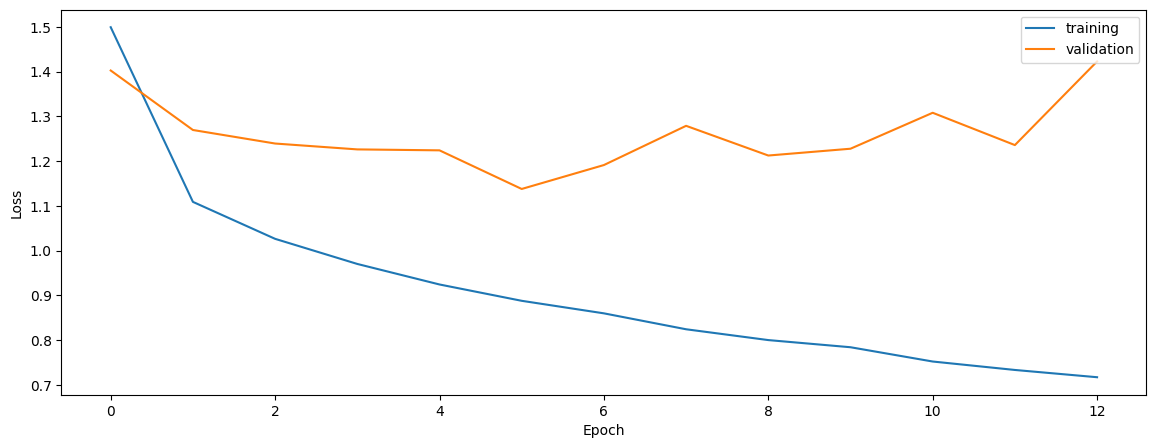

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6633391331745014
0.5598401784055008
0.6155761730879101


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6120923486165512
0.5541094809906926
0.5449493750988768


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6258627042391328
0.5957554725040043
0.5764483906770256


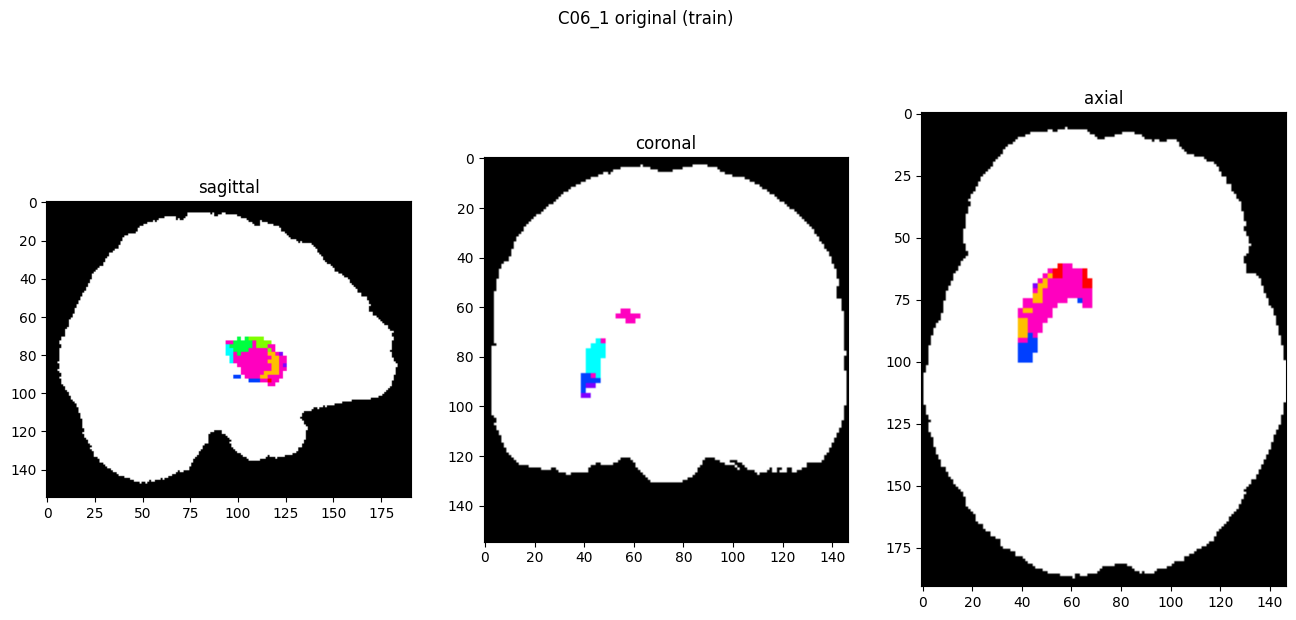

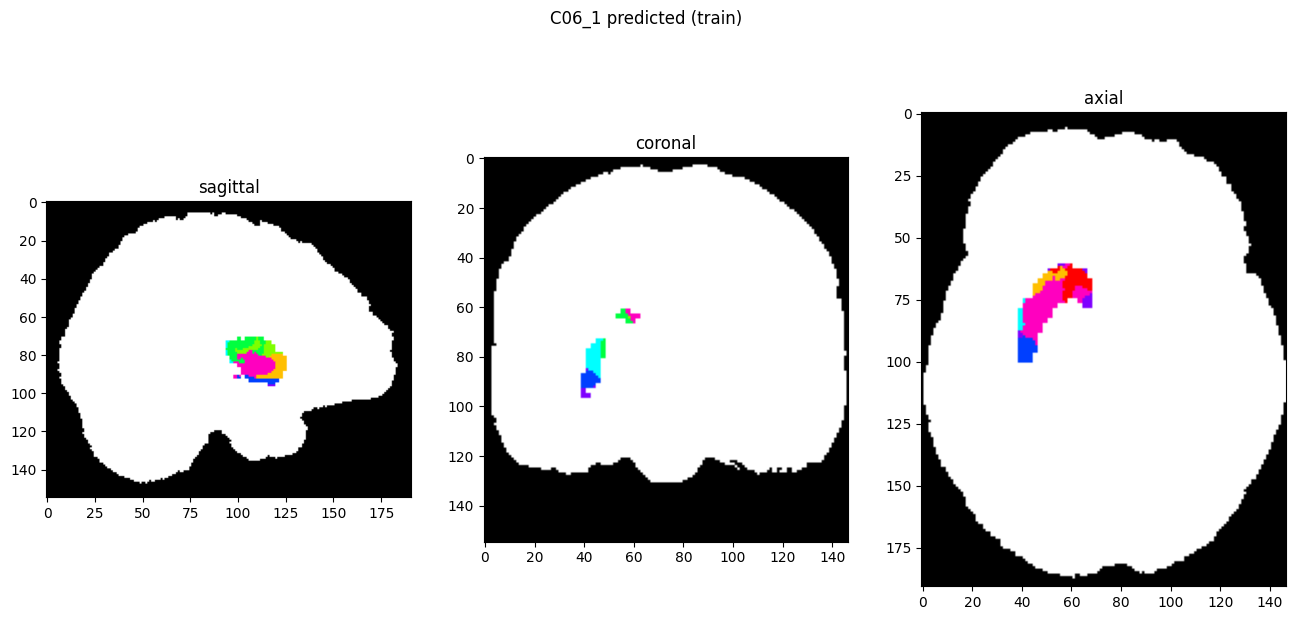

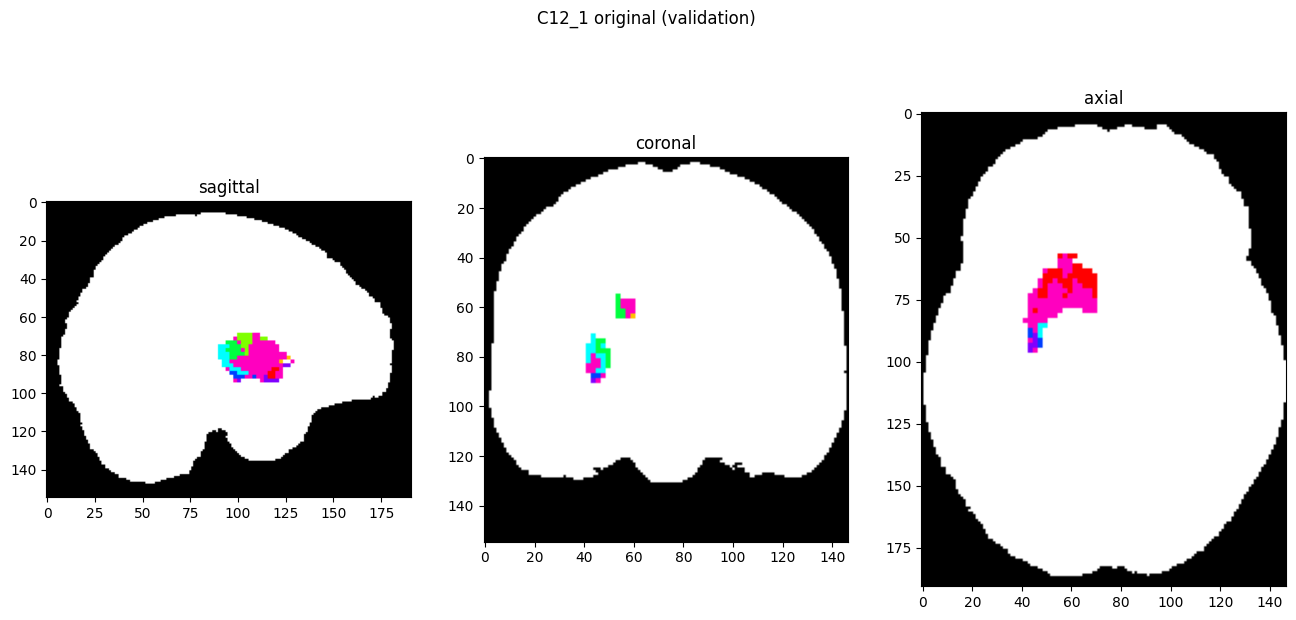

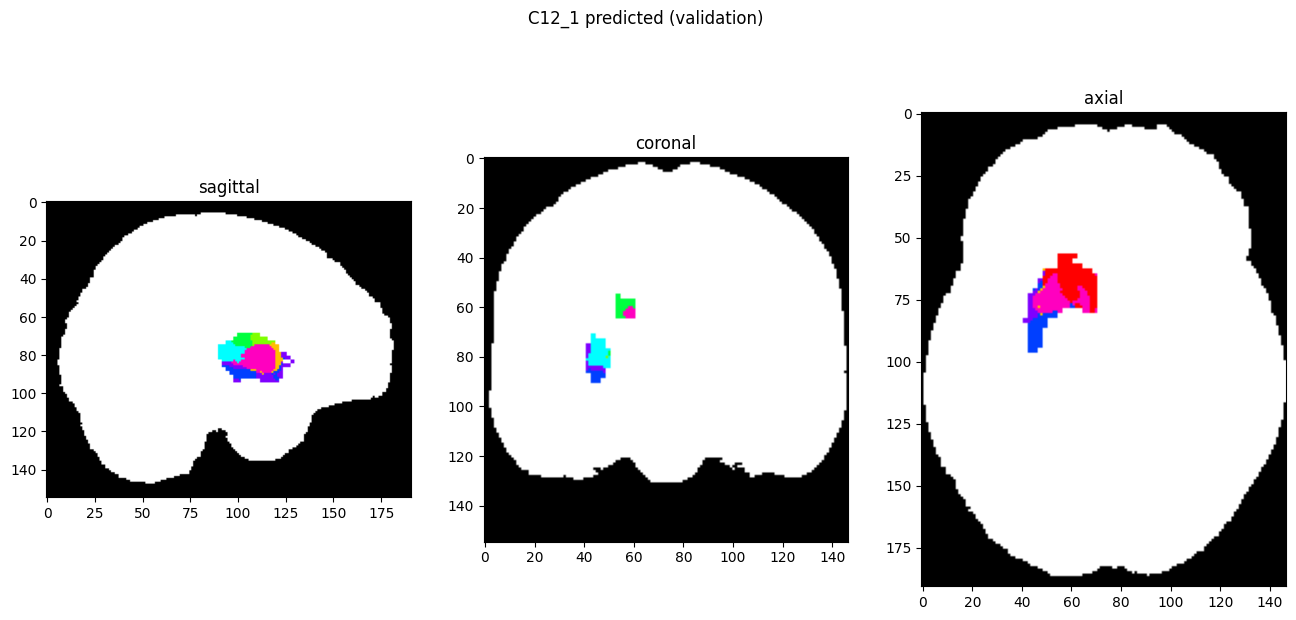

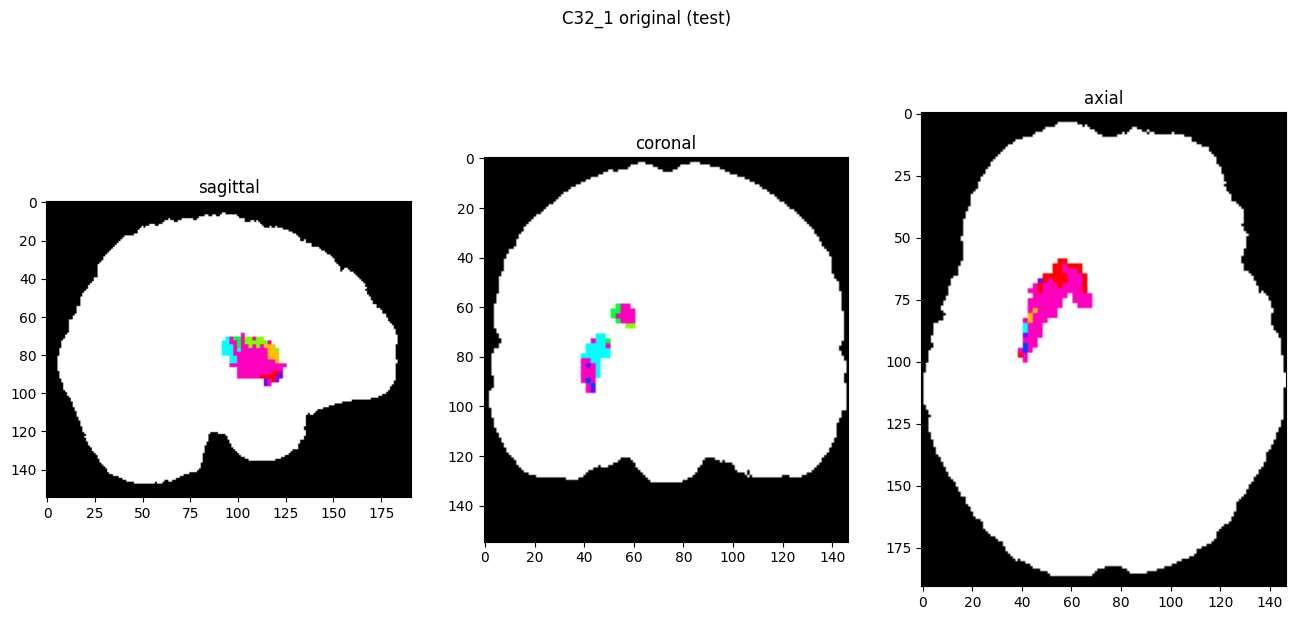

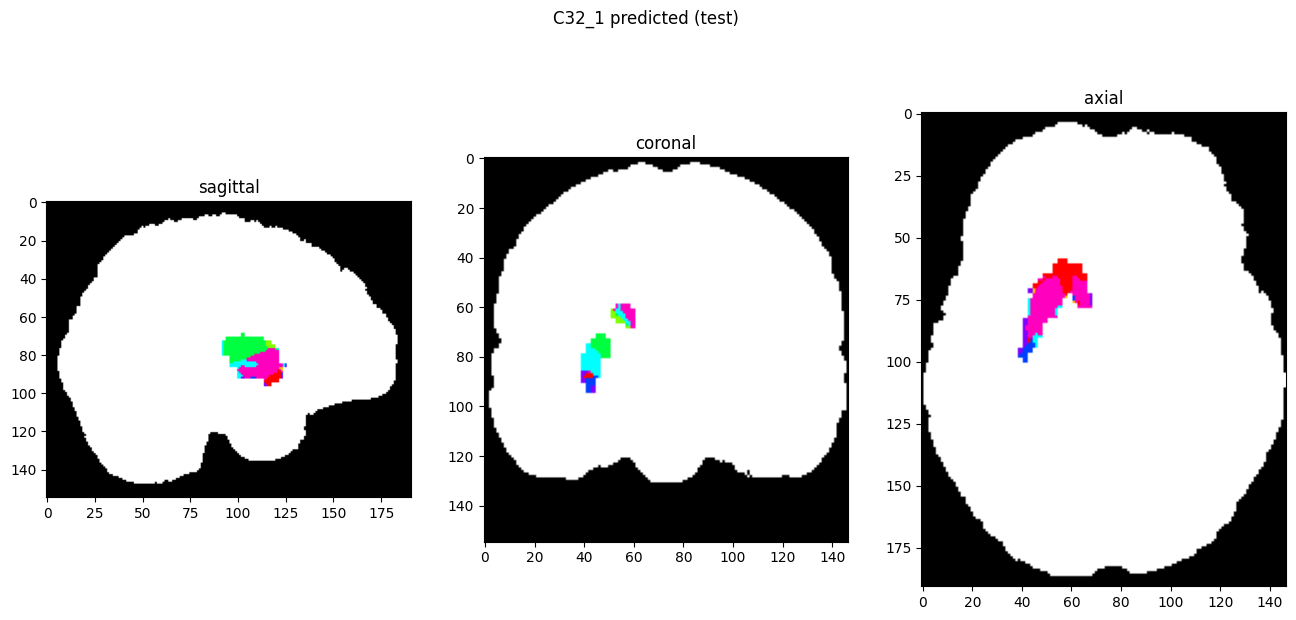

In [10]:
showResults(model, gen, threshold=0)